# **Dive into data careers**

 

 Desde a pandemia vivenciamos noticias como: [Brasil terá déficit de 530 mil profissionais de tecnologia até 2025, mostra estudo do Google](https://g1.globo.com/trabalho-e-carreira/noticia/2023/05/31/brasil-tera-deficit-de-530-mil-profissionais-de-tecnologia-ate-2025-mostra-estudo-do-google.ghtml) e os ditos "influenciadores", coaches e vendedores de curso prometendo altos ganhos de salários de forma rápida e com pouco esforço. Desse modo, impulsionando ainda mais o mercado de tecnologia que tem tido uma busca expressiva por parte das pessoas. 

 Nesse contexto, uma das áreas que mais tem se destacado é a área de dados. Com a explosão da quantidade de dados disponíveis e a crescente necessidade de extrair insights significativos deles, a demanda por profissionais qualificados em dados nunca foi tão alta. A promessa de carreiras lucrativas e repletas de oportunidades atrai cada vez mais pessoas em busca de atualização profissional e sucesso financeiro. Na imagem a seguir, apresentamos os dados referentes às buscas pelos termos "machine learning" e "ciencia de dados" no google, e podemos notar a clara tendência de crescimento iniciando em meados de 2016/2017 e o seu máximo em 2022/2024. 


<img src="../images/tendencias.png" alt="Tendencias" width="750"/>



Pode ser difícil a tomada de decisões assertivas em um mercado tão aquecido como o que estamos atualmente, principalmente quando consideramos a quantidade de informações que nos chegam a todo momento sobre a área. Diante desse cenário, surge a necessidade de uma compreensão mais aprofundada sobre as carreiras em dados. 

Desse modo, **"Dive into data careers"** é um projeto de análise de dados que busca oferecer insights que auxiliem indivíduos e profissionais a tomarem decisões mais assertivas.

---
# **Dados**

Para esse projeto utilizamos o dataset [Data Science Salaries 2024](https://www.kaggle.com/datasets/sazidthe1/data-science-salaries) onde, de acordo com o autor, os dados foram extraídos do site de empregos internacional [ai-jobs](https://ai-jobs.net/). 

Utilizou-se também o arquivo [countries.csv](https://developers.google.com/public-data/docs/canonical/countries_csv) para complementar a base com dados geográficos.

---
# **Objetivo**

A presente análise busca compreender quais são as carreiras de dados mais promissoras. Para tal, definiremos uma série de objetivos parciais listados a seguir:

* Buscamos entender como o efeito temporal modificou a
    * Criação de novos cargos e demanda por profissionais
    
    * Evolução salarial

* Entender a distribuição de salários dos profissionais da área

* Avaliar como o nível de experiencia de um individuo impacta em seu salário

* Investigar como o modelo de trabalho (remoto, híbrido, presencial) está relacionado com o salário

* Verificar se a localização geográfica de um individuo/empresa reflete no salario

* Compreender se o tamanho da empresa está associado ao salario.


---
# **Motivação**

O desenvolvimento deste trabalho é motivado e incentivado pelo clube de assinaturas da Universidade dos Dados pelo André Yukio. A presente competição tem como objetivo selecionar as melhores análises efetuadas nos dados propostos.

 

---
## **Importando pacotes**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import folium
from pycountry_convert import country_name_to_country_alpha2
import scipy.stats as scstats




# Configurações globais usando rcParams
plt.style.use('seaborn-v0_8-deep')
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['figure.figsize'] = (16, 6)

## **Funções**

In [2]:
def get_country_code(country):
    try:
        country_code =  country_name_to_country_alpha2(country)
    except:
        country_code = np.nan 

    return country_code

def obter_localizacao(country):
    df = pd.read_csv('../data/geolocation_data/countries.csv',index_col='code')

    return tuple(df.loc[get_country_code(f'{country}'),['latitude','longitude']]) 


def new_map():
    return  folium.Map(tiles='https://{s}.basemaps.cartocdn.com/dark_all/{z}/{x}/{y}{r}.png',attr='my-portfolium')

def add_country(mapa,country,text):
    localizacao =  obter_localizacao(country)
    folium.CircleMarker(location= localizacao,
                    radius=5,
                    color='red',
                    tooltip=text,
                    fill=True,
                    fill_color='red').add_to(mapa)

def variacao_percentual(valor_anterior, valor_atual):
    return (valor_atual-valor_anterior)/valor_anterior * 100


## **Carregando dados**

In [3]:
salarios = pd.read_csv('../data/career_data/data_science_salaries.csv')
salarios.head()

,job_title,experience_level,employment_type,work_models,work_year,employee_residence,salary,salary_currency,salary_in_usd,company_location,company_size
0,Data Engineer,Mid-level,Full-time,Remote,2024,United States,148100,USD,148100,United States,Medium
1,Data Engineer,Mid-level,Full-time,Remote,2024,United States,98700,USD,98700,United States,Medium
2,Data Scientist,Senior-level,Full-time,Remote,2024,United States,140032,USD,140032,United States,Medium
3,Data Scientist,Senior-level,Full-time,Remote,2024,United States,100022,USD,100022,United States,Medium
4,BI Developer,Mid-level,Full-time,On-site,2024,United States,120000,USD,120000,United States,Medium


## **Integridade da base**

verificando as dimensoes da base:

* 6599 instâncias

* 11 variáveis

In [4]:
salarios.shape

(6599, 11)

Sem valores duplicados

In [5]:
salarios.duplicated().sum()

0

Sem valores nulos

In [6]:
salarios.isna().sum()

job_title             0
experience_level      0
employment_type       0
work_models           0
work_year             0
employee_residence    0
salary                0
salary_currency       0
salary_in_usd         0
company_location      0
company_size          0
dtype: int64

Verificando com mais detalhes as variavéis e seus tipos

In [7]:
salarios.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6599 entries, 0 to 6598
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   job_title           6599 non-null   object
 1   experience_level    6599 non-null   object
 2   employment_type     6599 non-null   object
 3   work_models         6599 non-null   object
 4   work_year           6599 non-null   int64 
 5   employee_residence  6599 non-null   object
 6   salary              6599 non-null   int64 
 7   salary_currency     6599 non-null   object
 8   salary_in_usd       6599 non-null   int64 
 9   company_location    6599 non-null   object
 10  company_size        6599 non-null   object
dtypes: int64(3), object(8)
memory usage: 3.5 MB


Aparentemente tudo dentro dos conformes. Base pequena, poucos dados e ocupando pouca memoria (3.5MB)

Ponto de melhora : Alterar as variáveis object para string ou category

Variáveis/Features:

| Variável | Descrição |
|---|---|
| experience_level | Nível de experiência do indivíduo |
| employment_type | Tipo de contratação |
| work_models | Modelo de trabalho (remoto, home office e etc..) |
| work_year | Ano do emprego em questão. |
| employee_residence | Local de residência do empregado |
| salary | Salário informado na moeda local |
| salary_currency | Moeda em que o salário é denominado |
| salary_in_usd | Salário convertido para dolares |
| company_location | Local geográfico da empresa contratante |
| company_size | Tamanho da empresa categorizado de acordo com a quantidade de funcionários |
 



## **Obtendo estatísticas básicas**



In [8]:
salarios.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
work_year,6599.0,2022.82,0.67,2020.0,2023.0,2023.0,2023.0,2024.0
salary,6599.0,179283.26,526372.24,14000.0,96000.0,140000.0,187500.0,30400000.0
salary_in_usd,6599.0,145560.56,70946.84,15000.0,95000.0,138666.0,185000.0,750000.0


In [9]:
salarios.describe(include='object').T

,count,unique,top,freq
job_title,6599,132,Data Engineer,1307
experience_level,6599,4,Senior-level,4105
employment_type,6599,4,Full-time,6552
work_models,6599,3,On-site,3813
employee_residence,6599,87,United States,5305
salary_currency,6599,22,USD,5827
company_location,6599,75,United States,5354
company_size,6599,3,Medium,5860


**Insights**

* Observamos que ao menos 50% dos dados são referentes ao ano de 2023, obtemos isso comparando o 1°quartil com o 3°quartil, cuja diferença corresponde a 50%

* Os dados foram obtidos num intervalo de 5 anos, com inicio em 2020 e com fim em janeiro de 2024.

* Vamos ignorar o salário dado em termos regionais, pois não faz sentido olhar as estatísticas de um salario em dólar, outro salário dado em reais e um terceiro em libras esterlinas. Faz mais sentido olharmos para todos os salários convertidos para dólares, é como se estivessem em uma mesma escala.

* O dono do dataset não apresenta muitas informações acerca do salário, mas suponhamos que sejam salários anuais, visto que é uma prática muito comum na gringa.

* O maior salário corresponde a \\$750.000 anuais, ou  R\\$312.500 por mês tomando uma cotação de 1 para 5

* O menor salário corresponde a \\$15.000 anuais. O que equivale a R\\$6.250 por mês no Brasil, tomando uma cotação de 5 reais o dólar

* Metade dos salários se encontram entre \\$90.000 anuais. Equivalente em R\\$37.500 por mês. Resultado obtido através da subtração do salário em dólares do 3° quartil com o 1° quartil. 

* O desvio padrão é alto e equivale a \\$70.946,84, cerca de R\\$354.734,20 por ano.

* Na mediana o salário se encontra em \\$138.666, equivalente a R\\$57.777,50 por mês.

* Observamos que a Mediana e a Média são relativamente próximas.

* O cargo com maiores contratações corresponde ao do Engenheiro de dados, com 1307 (19,81\%) instâncias

* A maioria das contratações ocorrem para indivíduos em nível senior. São 4105 (62,21\%) instâncias 

* Os trabalhos em sua maioria (99,29\%) são em regime integral. 

* Cerca de 57,78\% de todos os trabalhos são presenciais.

* Grande parte de todos os trabalhos estão sendo pago em Dólares.

* A maioria das empresas são dos Estados Unidos.

* 88,80\% das empresas são consideradas de porte médio. 

## **Análise exploratória dos dados**

---
**Job Title / Profissão**


São 132 cargos diferentes

In [10]:
salarios['job_title'].nunique()

132

Exibindo todos os cargos

In [11]:
salarios['job_title'].unique()

array(['Data Engineer', 'Data Scientist', 'BI Developer',
       'Research Analyst', 'Business Intelligence Developer',
       'Data Analyst', 'Director of Data Science', 'MLOps Engineer',
       'Machine Learning Scientist', 'Machine Learning Engineer',
       'Data Science Manager', 'Applied Scientist',
       'Business Intelligence Analyst', 'Analytics Engineer',
       'Business Intelligence Engineer', 'Data Science',
       'Research Scientist', 'Research Engineer',
       'Managing Director Data Science', 'AI Engineer', 'Data Specialist',
       'Data Architect', 'Data Visualization Specialist', 'ETL Developer',
       'Data Science Practitioner', 'Computer Vision Engineer',
       'Data Lead', 'ML Engineer', 'Data Developer', 'Data Modeler',
       'Data Science Consultant', 'AI Architect',
       'Data Analytics Manager', 'Data Science Engineer',
       'Data Product Manager', 'Data Quality Analyst', 'Data Strategist',
       'Prompt Engineer', 'Data Science Lead',
       'Busi

Analisando a lista de profissões, nós identificamos algumas redundâncias, por exemplo:  Dentre as profissões há Machine Learning Engineer e ML Engineer, temos também Data Scientist e Data Science.

Pedi ao chatgpt me indicar todas as possíveis redundâncias na lista, e a sua resposta após alguns prompts está listada a seguir:

>1. **Business Intelligence Developer** e **BI Developer**: Ambos os termos se referem a desenvolvedores de inteligência de negócios, e "BI" é uma abreviação comum para "Business Intelligence".
>
>2. **Data Analyst** e **Business Data Analyst**: Ambos os profissionais estão envolvidos na análise de dados para fins comerciais, e a inclusão de "Business" em "Business Data Analyst" não adiciona uma distinção significativa.
>3. **Machine Learning Engineer** e **ML Engineer**: "ML" é uma abreviação comum para "Machine Learning", então ambos os termos descrevem a mesma função.
>4. **Data Manager** e **Data Management Analyst**: Ambos estão envolvidos na gestão de dados, e a inclusão de "Analyst" em "Data Management Analyst" não adiciona uma distinção significativa.
>5. **Data Quality Analyst** e **Data Quality Engineer**: Ambos estão envolvidos na garantia da qualidade dos dados, e a inclusão de "Engineer" em "Data Quality Engineer" não adiciona uma distinção significativa.
>6. **Data Quality Manager** e **Data Quality Engineer**: Ambos estão envolvidos na gestão da qualidade dos dados, e a inclusão de "Manager" em "Data Quality Manager" não adiciona uma distinção significativa.
>7. **Data Visualization Specialist** e **Data Visualization Engineer**: Ambos estão envolvidos na visualização de dados, e a inclusão de "Engineer" em "Data Visualization Engineer" não adiciona uma distinção significativa.
>8. **Machine Learning Scientist** e **Principal Data Scientist**: Ambos os termos descrevem profissionais que trabalham com algoritmos de aprendizado de máquina e análise de dados, e a inclusão de "Principal" não adiciona uma distinção significativa.
>9. **Principal Machine Learning Engineer** e **Staff Machine Learning Engineer**: Ambos os termos descrevem profissionais que trabalham com algoritmos de aprendizado de máquina, e a inclusão de "Principal" ou "Staff" não adiciona uma distinção significativa.
>10. **Lead Machine Learning Engineer** e **Machine Learning Manager**: Ambos os termos descrevem profissionais que lideram projetos de aprendizado de máquina, e a inclusão de "Lead" em "Lead Machine Learning Engineer" não adiciona uma distinção significativa.
>11. **Marketing Data Scientist** e **Marketing Data Analyst**: Ambos os profissionais estão envolvidos na análise de dados para fins de marketing, e a inclusão de "Scientist" em "Marketing Data Scientist" não adiciona uma distinção significativa.
>12. **AI Scientist** e **AI Research Engineer**: Ambos os termos descrevem profissionais que trabalham com inteligência artificial, e a inclusão de "Engineer" em "AI Research Engineer" não adiciona uma distinção significativa.
>13. **Data Integration Specialist** e **Data Integration Engineer**: Ambos estão envolvidos na integração de sistemas e dados, e a inclusão de "Engineer" em "Data Integration Engineer" não adiciona uma distinção significativa.
>14. **Data Management Specialist** e **Manager Data Management**: Ambos estão envolvidos na gestão de dados, e a inclusão de "Manager" em "Manager Data Management" não adiciona uma distinção significativa.
>15. **Data Scientist** e **Data Science**: Ambos estão relacionados ao campo geral de ciência de dados, com "Data Scientist" representando um profissional e "Data Science" representando a disciplina como um todo.

Para uma primeira exploração esse resultado me parece interessante.

Realizar o replace pode ou não ser interessante dependendo do que desejamos analisar. Explico:

1. A redundância pode ser interessante para termos noção de quantos termos existem no mercado para um mesmo cargo.

2. Ter muitas variedades para o mesmo cargo pode ser prejudicial caso queiramos analisar qual a profissão mais "popular". Com muitas variantes, seria mais complicado realizar esse tipo de análise, pois devemos garantir que todas as variantes de um cargo sejam incluídas na análise. Um exemplo seria o caso de querermos analisar  o cargo com mais contratações, teríamos que levar em consideração todas as variantes desse cargo.


Verificando a proporção de cargos 

In [12]:
aux = salarios['job_title'].value_counts(1).sort_values(ascending=False).mul(100).nlargest(26).round(2).to_frame('proporcao')
aux['cumsum'] = aux['proporcao'].cumsum()
aux

,proporcao,cumsum
job_title,,
Data Engineer,19.81,19.81
Data Scientist,18.84,38.65
Data Analyst,13.79,52.44
Machine Learning Engineer,9.53,61.97
Analytics Engineer,3.73,65.70
Research Scientist,3.12,68.82
Data Architect,2.67,71.49
Research Engineer,2.06,73.55
ML Engineer,1.71,75.26


**Insights**

* São registradas 132 profissões diferentes relacionadas a dados

* Existem redundâncias, por exemplo:  Dentre as profissões há Machine Learning Engineer e ML Engineer, temos também Data Scientist e Data Science.

* Há muitas profissões na área de dados, mas as três principais são Engenharia de dados (19,81%), Ciência de dados (18,84%) e Análista de dados (13,79%). Juntas, elas correspondem a 52,44% de toda a base sem levar em consideração as redundâncias.


---
**Experience level / Nível de experiência**

Verificando os níveis de experiência

In [13]:
salarios['experience_level'].unique().tolist()

['Mid-level', 'Senior-level', 'Entry-level', 'Executive-level']

Verificando a proporção do nível de experiência 

In [14]:
aux = salarios['experience_level'].value_counts(1).sort_values(ascending=False).mul(100).round(2).to_frame('proporcao')
aux['cumsum'] = aux['proporcao'].cumsum()
aux

,proporcao,cumsum
experience_level,,
Senior-level,62.21,62.21
Mid-level,25.38,87.59
Entry-level,8.56,96.15
Executive-level,3.85,100.00


**Insights**

* Existem 4 níveis de experiencia que distinguem os profissionais de dados.
    * Senior-level corresponde ao sênior
    
    * Mid-level é o equivalente a pleno
    * Entry-level seria o Junior, e aqui não sabemos se trainee e estagiários são levados e consideração
    * Executive-level corresponde aos profissionais voltados ao negócio.
    
* O sênior é o tipo de profissional mais requisitado pelo mercado, onde 62,21\% da base corresponde a esse tipo.

* Com 25,38% vem o profissional pleno

* Com 8,56% estão os juniores.

* E os profissionais executivos com 3,85%
    

___

**work_models / Modelo de trabalho**

Verificando os modelos de trabalho

In [15]:
salarios['work_models'].unique()

array(['Remote', 'On-site', 'Hybrid'], dtype=object)

Verificando a proporção de cada modelo

In [16]:
aux = salarios['work_models'].value_counts(1).sort_values(ascending=False).mul(100).round(2).to_frame('proporcao')
aux['cumsum'] = aux['proporcao'].cumsum()
aux

,proporcao,cumsum
work_models,,
On-site,57.78,57.78
Remote,38.81,96.59
Hybrid,3.41,100.00


**Insights**

* 57.78\% dos trabalhos são presenciais e 38,81\% são remotos

* Trabalhos híbridos são a minoria, representando 3,41\% da base.

---
**Work_year / Ano**


Verificando a quantidade absoluta de cargos por ano

Text(0, 0.5, 'Quantidade de cargos na plataforma')

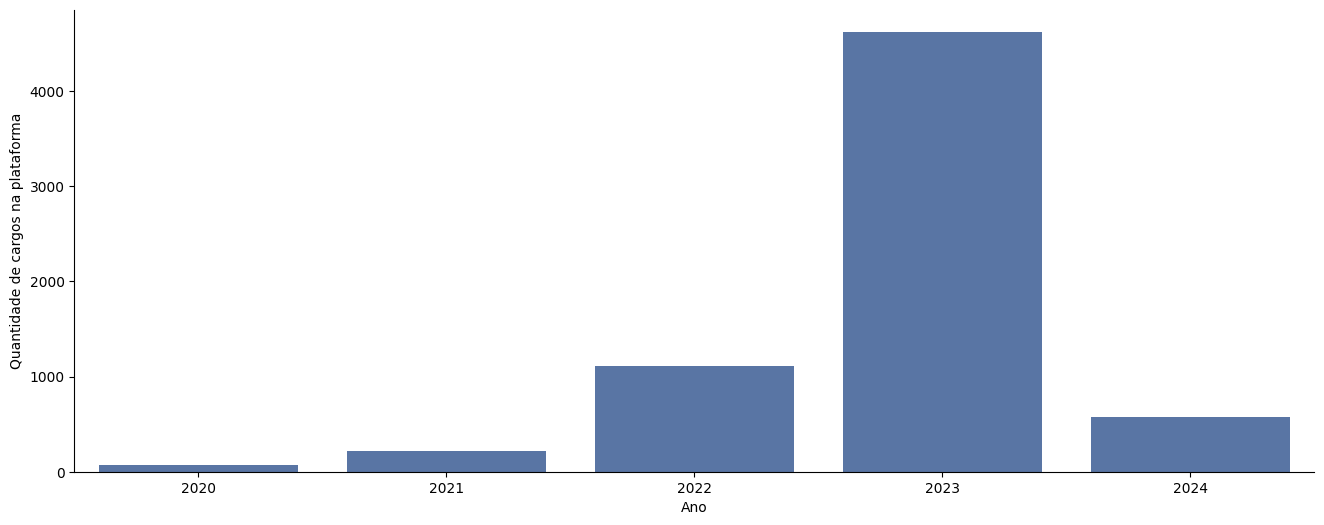

In [17]:
sns.countplot(data=salarios,x='work_year');
plt.xlabel('Ano')
plt.ylabel('Quantidade de cargos na plataforma')

A contagem absoluta nos diz respeito sobre a popularidade do site, e não sobre a criação de novos cargos. Do gráfico logo a cima, notamos o crescimento ano a ano na frequência absoluta de cargos oferecidos pelo site.

**Insights**

* Notamos que a quantidade de empregos não é uniforme com o tempo. O aumento do uso da plataforma  é notável com o passar dos anos. Isso pode ter ocorrido devido a plataforma ter ficado popular? o Boom da área de dados?

* Apesar de termos apenas o mês de janeiro em 2024, já podemos notar que o nível de empregos no site é maior quando comparado a 2020 e 2021

---
**employee_residence / Residência do empregado**

Verificando a quantidade de países onde os empregados residem

In [18]:
salarios['employee_residence'].nunique()

87

Listando os países

In [19]:
salarios['employee_residence'].unique()

array(['United States', 'Romania', 'Portugal', 'Lebanon', 'India',
       'Ireland', 'United Kingdom', 'Spain', 'Egypt', 'Germany', 'Canada',
       'Australia', 'Vietnam', 'Uganda', 'Italy', 'Thailand',
       'Philippines', 'Tunisia', 'Belgium', 'Turkey', 'Nigeria',
       'Uzbekistan', 'Argentina', 'France', 'Kuwait', 'Ukraine',
       'South Africa', 'Slovenia', 'Singapore', 'Sweden', 'Saudi Arabia',
       'Armenia', 'Russia', 'Georgia', 'Qatar', 'Peru', 'Poland',
       'New Zealand', 'Norway', 'Netherlands', 'Mexico', 'Latvia',
       'Pakistan', 'Lithuania', 'South Korea', 'Kenya', 'Moldova',
       'Israel', 'Hungary', 'Croatia', 'Hong Kong', 'Greece', 'Ghana',
       'Finland', 'Estonia', 'Cyprus', 'Ecuador', 'Austria', 'Colombia',
       'Switzerland', 'Central African Republic', 'Czech Republic',
       'Brazil', 'Bosnia and Herzegovina', 'Andorra', 'China',
       'Costa Rica', 'Chile', 'Bolivia', 'Malaysia',
       'United Arab Emirates', 'Puerto Rico', 'Japan', 'Iran',
 

Verificando a proporção de cada país

In [20]:
aux = salarios['employee_residence'].value_counts(1).sort_values(ascending=False).mul(100).round(2).to_frame('proporcao')
aux['cumsum'] = aux['proporcao'].cumsum()
aux.head(20)

,proporcao,cumsum
employee_residence,,
United States,80.39,80.39
United Kingdom,6.08,86.47
Canada,3.65,90.12
Germany,1.08,91.20
India,1.06,92.26
Spain,1.02,93.28
France,0.80,94.08
Australia,0.44,94.52
Portugal,0.42,94.94


Mapa interativo com a localidade de cada profissional

In [21]:
mapa_empregados = new_map()

for country in salarios['employee_residence'].unique():
    qte = salarios.query(f"employee_residence == '{country}'").shape[0]
    texto = f"{country}: {qte} trabalhadores"
    add_country(mapa_empregados,country,texto)

mapa_empregados

/home/alexandre/.cache/pypoetry/virtualenvs/dive-into-data-careers-Vh_zOGtm-py3.10/lib/python3.10/site-packages/pycountry/db.py:51: UserWarning: Country's official_name not found. Country name provided instead.
  warnings.warn(warning_message, UserWarning)
/home/alexandre/.cache/pypoetry/virtualenvs/dive-into-data-careers-Vh_zOGtm-py3.10/lib/python3.10/site-packages/pycountry/db.py:51: UserWarning: Country's common_name not found. Country name provided instead.
  warnings.warn(warning_message, UserWarning)


**Insights**

* Observamos pessoas de 87 países diferentes.

* A maioria das pessoas (80,39\%) residem nos Estados Unidos.

* O Brasil se encontra em 12° com 0,29\% da base. 

* O top 10 é formado majoritariamente por países da América do Norte e Europa, exceto pela India e Australia.

---
**company_location / Localização da empresa**

Verificando os países onde as empresas estão instaladas

In [22]:
salarios['company_location'].nunique()

75

Listando os países

In [23]:
salarios['company_location'].unique()

array(['United States', 'Romania', 'Portugal', 'Lebanon', 'India',
       'Ireland', 'United Kingdom', 'Spain', 'Egypt', 'Germany', 'Canada',
       'Australia', 'Vietnam', 'Ukraine', 'Turkey', 'Thailand',
       'South Africa', 'Slovenia', 'Singapore', 'Sweden', 'Saudi Arabia',
       'Russia', 'Qatar', 'Poland', 'Philippines', 'New Zealand',
       'Norway', 'Netherlands', 'Nigeria', 'Mexico', 'Latvia',
       'Luxembourg', 'Lithuania', 'South Korea', 'Kenya', 'Japan',
       'Italy', 'Israel', 'Hungary', 'Croatia', 'Hong Kong', 'Greece',
       'Gibraltar', 'Ghana', 'France', 'Finland', 'Estonia', 'Ecuador',
       'Denmark', 'Czech Republic', 'Colombia', 'Switzerland',
       'Central African Republic', 'Brazil', 'Bosnia and Herzegovina',
       'Armenia', 'Argentina', 'Andorra', 'United Arab Emirates',
       'Puerto Rico', 'Pakistan', 'Malaysia', 'Iran', 'Indonesia',
       'Algeria', 'Belgium', 'Austria', 'Malta', 'Moldova', 'Iraq',
       'China', 'Chile', 'Bahamas', 'Mauritius

Verificando a proporção de cada país

In [24]:
aux = salarios['company_location'].value_counts(1).sort_values(ascending=False).mul(100).round(2).to_frame('proporcao')
aux['cumsum'] = aux['proporcao'].cumsum()
aux.head(20)

,proporcao,cumsum
company_location,,
United States,81.13,81.13
United Kingdom,6.18,87.31
Canada,3.68,90.99
Germany,1.18,92.17
Spain,0.95,93.12
India,0.88,94.00
France,0.74,94.74
Australia,0.48,95.22
Portugal,0.39,95.61


Mapa interativo exibindo a localidade das empresas

In [25]:
mapa_empresas = new_map()

for country in salarios['company_location'].unique():
    qte = salarios.query(f"company_location == '{country}'").shape[0]
    texto = f"{country}: {qte} empresas"
    add_country(mapa_empresas,country,texto)
    
mapa_empresas

**Insights**

* As empresas européias e norte americanas são as que  mais contratam.

---

**company_size / Tamanho da empresa**

Verificando o tamanho das empresas

In [26]:
aux = salarios['company_size'].value_counts(1).sort_values(ascending=False).mul(100).round(2).to_frame('proporcao')
aux['cumsum'] = aux['proporcao'].cumsum()
aux

,proporcao,cumsum
company_size,,
Medium,88.80,88.80
Large,8.62,97.42
Small,2.58,100.00


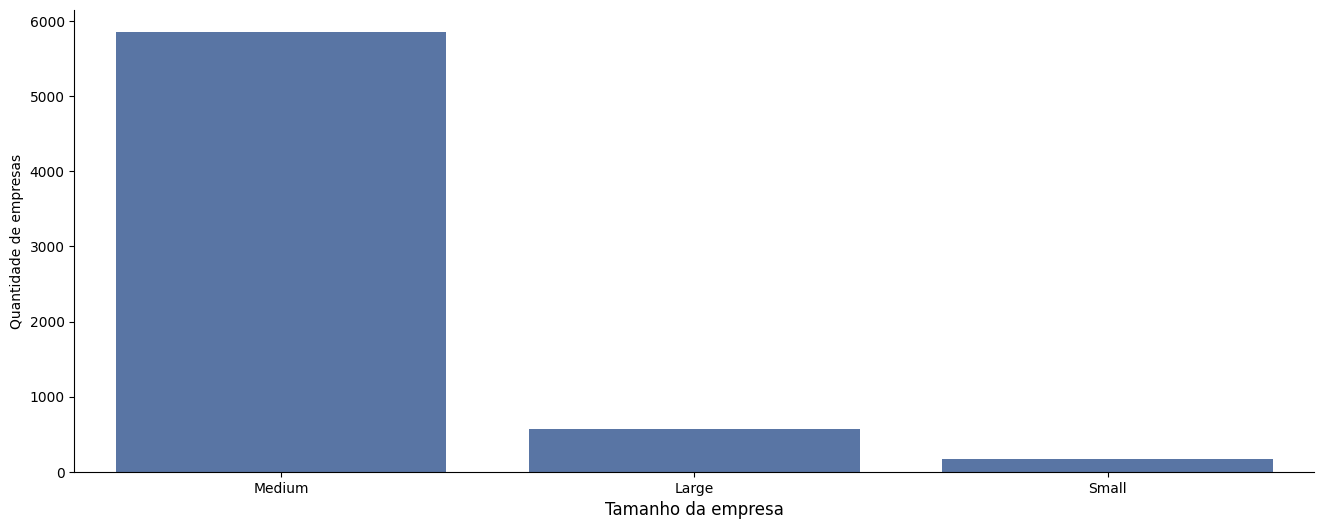

In [27]:
sns.countplot(data=salarios,x='company_size');
plt.xlabel('Tamanho da empresa',size=12)
plt.ylabel('Quantidade de empresas');

**Insights**

* Observamos que a maioria das empresas são de tamanho médio (88,80\%). Um tamanho médio talvez possa ser considerado por algumas centenas de empregados. Isso pode nos indicar certa maturidade das empresas presentes na base. 

---
**salary_currency / Moeda**

Verificando quantas moedas diferentes temos na base

In [28]:
salarios['salary_currency'].nunique()

22

Verificando a proporção de cada moeda

In [29]:
aux = salarios['salary_currency'].value_counts(1).sort_values(ascending=False).mul(100).round(2).to_frame('proporcao')
aux['cumsum'] = aux['proporcao'].cumsum()
aux

,proporcao,cumsum
salary_currency,,
USD,88.30,88.30
GBP,5.06,93.36
EUR,4.42,97.78
INR,0.77,98.55
CAD,0.59,99.14
AUD,0.17,99.31
PLN,0.11,99.42
SGD,0.09,99.51
CHF,0.08,99.59


**Insights**

* Há moedas de 22 países diferentes em negociação, apesar de termos empresas de 75 países diferentes e pessoas de 87 países diferentes.

* As moedas mais presentes são o Dólar, Euro, Libra Esterlina, Rupia indiana, Dólar Canadense e etc...

---
**salary_in_usd / Salario em dólar**

Verificando o salário de 95% dos profissionais

In [30]:
x95_sup = np.quantile(salarios['salary_in_usd'],0.975)
x95_inf = np.quantile(salarios['salary_in_usd'],0.025)
print(f"95% dos profissionais tem salario entre ${x95_inf} e ${x95_sup}")

95% dos profissionais tem salario entre $38000.0 e $300000.0


Text(0.5, 9.444444444444459, 'Salário em dólares')

/home/alexandre/.cache/pypoetry/virtualenvs/dive-into-data-careers-Vh_zOGtm-py3.10/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 74.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


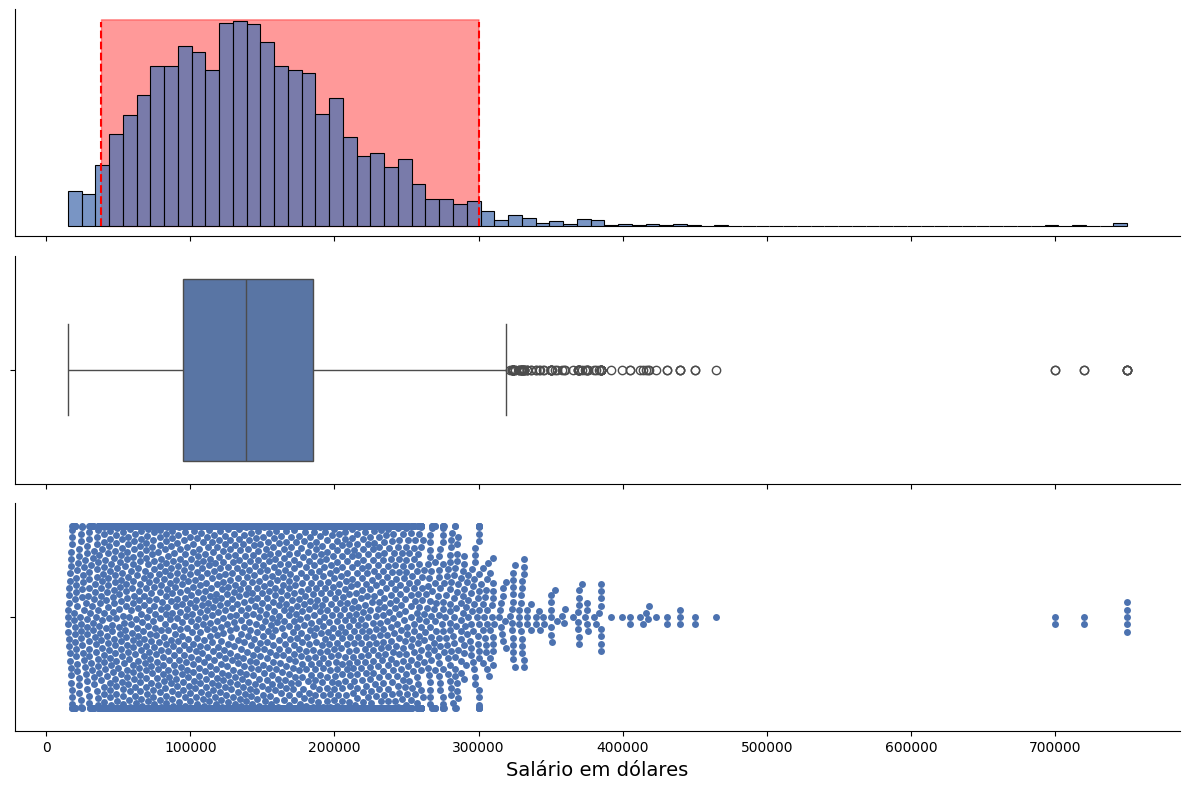

In [31]:
fig, ax = plt.subplots(3,1,tight_layout=True,figsize=(12,8),sharex=True)


ax[0].fill_between([x for x in range(int(x95_inf),int(x95_sup))],0,405,alpha=0.4,color='red')
sns.histplot(data=salarios,x='salary_in_usd',ax=ax[0])
ax[0].set_ylabel('')
ax[0].set_yticks(ticks=[])
ax[0].vlines(x=x95_sup,ymin = -0.05,ymax = 400,color='red',linestyles='--')
ax[0].vlines(x=x95_inf,ymin = -0.05,ymax = 400,color='red',linestyles='--')


sns.boxplot(data=salarios,x='salary_in_usd',ax=ax[1])


sns.swarmplot(data=salarios,x='salary_in_usd', ax=ax[2])

ax[2].set_xlabel('Salário em dólares',size=14);

Verificando a assimetria dos salários

In [32]:
salarios['salary_in_usd'].skew()

1.3607055055089352

In [33]:
salarios['salary_in_usd'].describe()

count      6599.000000
mean     145560.558569
std       70946.838070
min       15000.000000
25%       95000.000000
50%      138666.000000
75%      185000.000000
max      750000.000000
Name: salary_in_usd, dtype: float64

**Insights**

* Notamos que os salários seguem uma distribuição assimétrica a direita, com uma assimetria de 1.36

* 95\% das pessoas recebem entre \$38.000,00 e \$300.000,00

* Notamos a presença de outliers com salários muito acima do que grande parte das pessoas. Não temos como saber se são dados verídicos ou algum erro.


## **Pré-processamento dos dados**

Antes de iniciar o estudo é necessário realizar um simples pré-processamento dos dados, pois notamos a presença de uma vasta lista de profissões contendo variações de nome para um mesmo cargo. 

Partimos do princípio que para realizarmos um estudo justo, é necessário uma amostragem suficiente para cada cargo.

Removendo as redundâncias

In [34]:
to_replace = {
    "Business Intelligence Developer": "BI Developer",
    "Business Data Analyst": "Data Analyst",
    "ML Engineer": "Machine Learning Engineer",
    "Data Management Analyst": "Data Manager",
    "Data Quality Engineer": "Data Quality Analyst",
    "Data Quality Engineer": "Data Quality Manager",
    "Data Visualization Engineer": "Data Visualization Specialist",
    "Principal Data Scientist": "Machine Learning Scientist",
    "Staff Machine Learning Engineer": "Principal Machine Learning Engineer",
    "Machine Learning Manager": "Lead Machine Learning Engineer",
    "Marketing Data Analyst": "Marketing Data Scientist",
    "AI Research Engineer": "AI Scientist",
    "Data Integration Engineer": "Data Integration Specialist",
    "Manager Data Management": "Data Management Specialist",
    "Data Science": "Data Scientist"
}

salarios_sem_redundancia = salarios.replace(to_replace)

Obtendo as estatísticas da quantidade de cargos após a remoção das redundâncias

In [35]:
contagem = salarios_sem_redundancia['job_title'].value_counts().to_frame('contagem')

contagem.describe()

,contagem
count,118.000000
mean,55.923729
std,199.648587
min,1.000000
25%,2.000000
50%,6.000000
75%,17.750000
max,1307.000000


Estarei considerando apenas os cargos com amostragens acima de 30.

In [36]:
nomes = contagem.query('contagem >= 30').index

estudo = salarios_sem_redundancia.set_index('job_title').loc[nomes,:].reset_index()

estudo.shape

(5887, 11)

O nosso dataset ainda continua com uma quantidade de linhas considerável, mesmo após a remoção de algumas instâncias. 

Obtemos um dataset com apenas 22 cargos, entretanto, com amostras suficiente para realizar um estudo estatístico.

In [37]:
estudo['job_title'].nunique()

22

## **Carreiras mais promissoras**

### **Definição**
* Vamos estar considerando uma carreira promissora aquela que oferece oportunidades de remuneração competitiva, modelo de emprego, qualidade de vida em termos de moradia e localização da empresa.

* Será considerado também a variação percentual do salário ano a ano. 

### **1. Como o tamanho da empresa impacta no salário dos funcionários** 

Média dos salários por tamanho da empresa ano a ano

In [38]:
estudo.pivot_table(index = 'company_size',columns='work_year',values='salary_in_usd', margins=True).round(2)

work_year,2020,2021,2022,2023,2024,All
company_size,,,,,,
Large,112598.21,106884.61,117148.66,133112.17,158554.55,121833.17
Medium,129299.27,84268.79,137489.53,153788.72,153219.93,150700.74
Small,70761.71,94587.03,80125.60,89160.50,NaN,85449.75
All,103178.41,99740.75,133020.59,152407.92,153329.00,147306.66


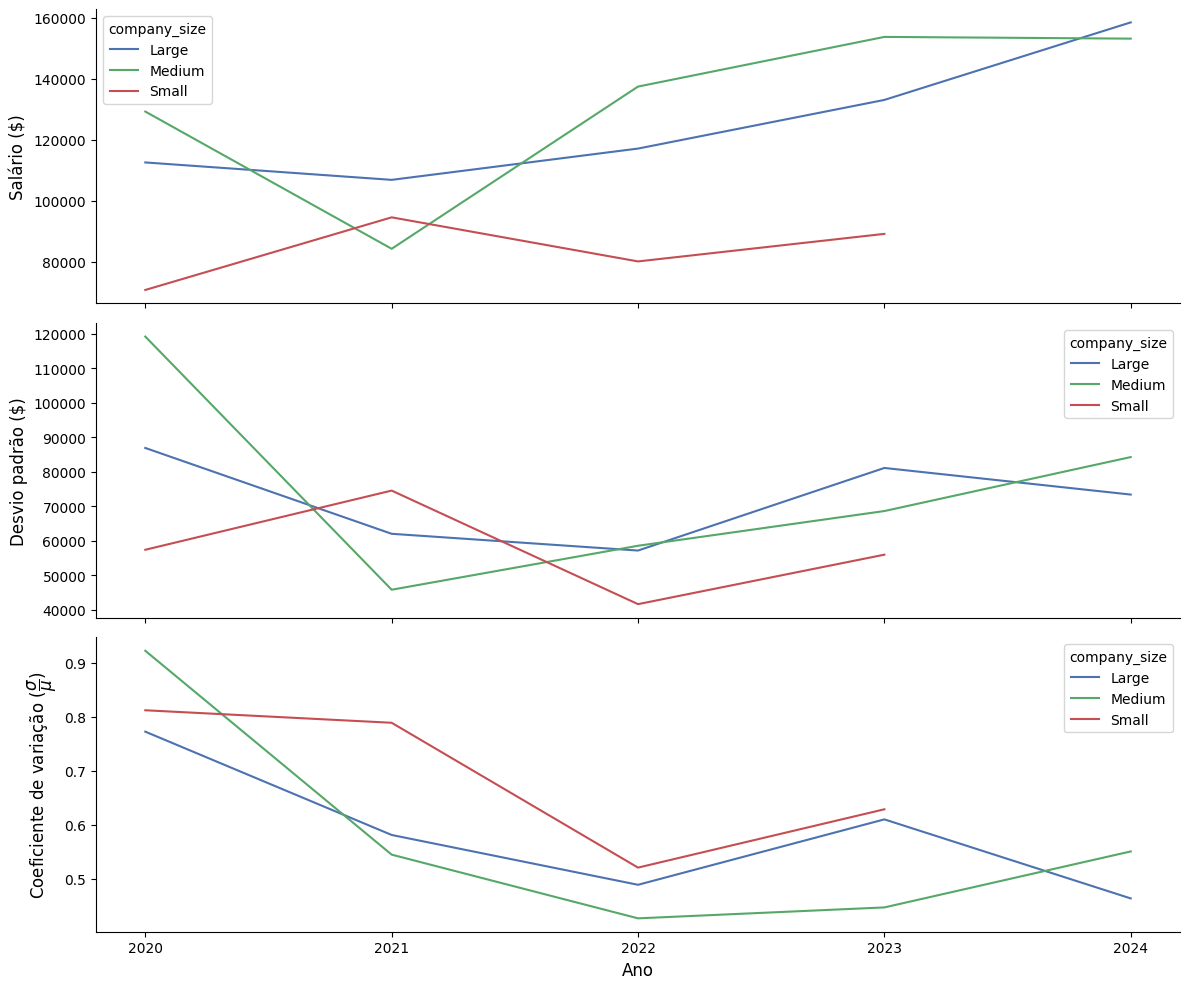

In [39]:
aux_salarios = estudo.groupby(['work_year','company_size'])['salary_in_usd'].agg(['mean','std']).round(2).reset_index()
aux_salarios['coeficiente_variacao'] = aux_salarios['std']/aux_salarios['mean']

fig,ax = plt.subplots(3,1,tight_layout=True,figsize=(12,10),sharex=True)

sns.lineplot(data=aux_salarios,x='work_year',y='mean',hue='company_size',ax=ax[0])
ax[0].set_ylabel('Salário ($)',size=12)


sns.lineplot(data=aux_salarios,x='work_year',y='std',hue='company_size',ax=ax[1])
ax[1].set_ylabel('Desvio padrão ($)',size=12)
ax[1].set_xlabel('Ano',size=12)
ax[1].set_xticks(ticks=[2020,2021,2022,2023,2024]);

sns.lineplot(data=aux_salarios,x='work_year',y='coeficiente_variacao',hue='company_size',ax=ax[2])
ax[2].set_ylabel('Coeficiente de variação $(\dfrac{\sigma}{\mu})$',size=12)
ax[2].set_xlabel('Ano',size=12)
ax[2].set_xticks(ticks=[2020,2021,2022,2023,2024]);

fig.savefig('../images/salarioxtamempresa.png')

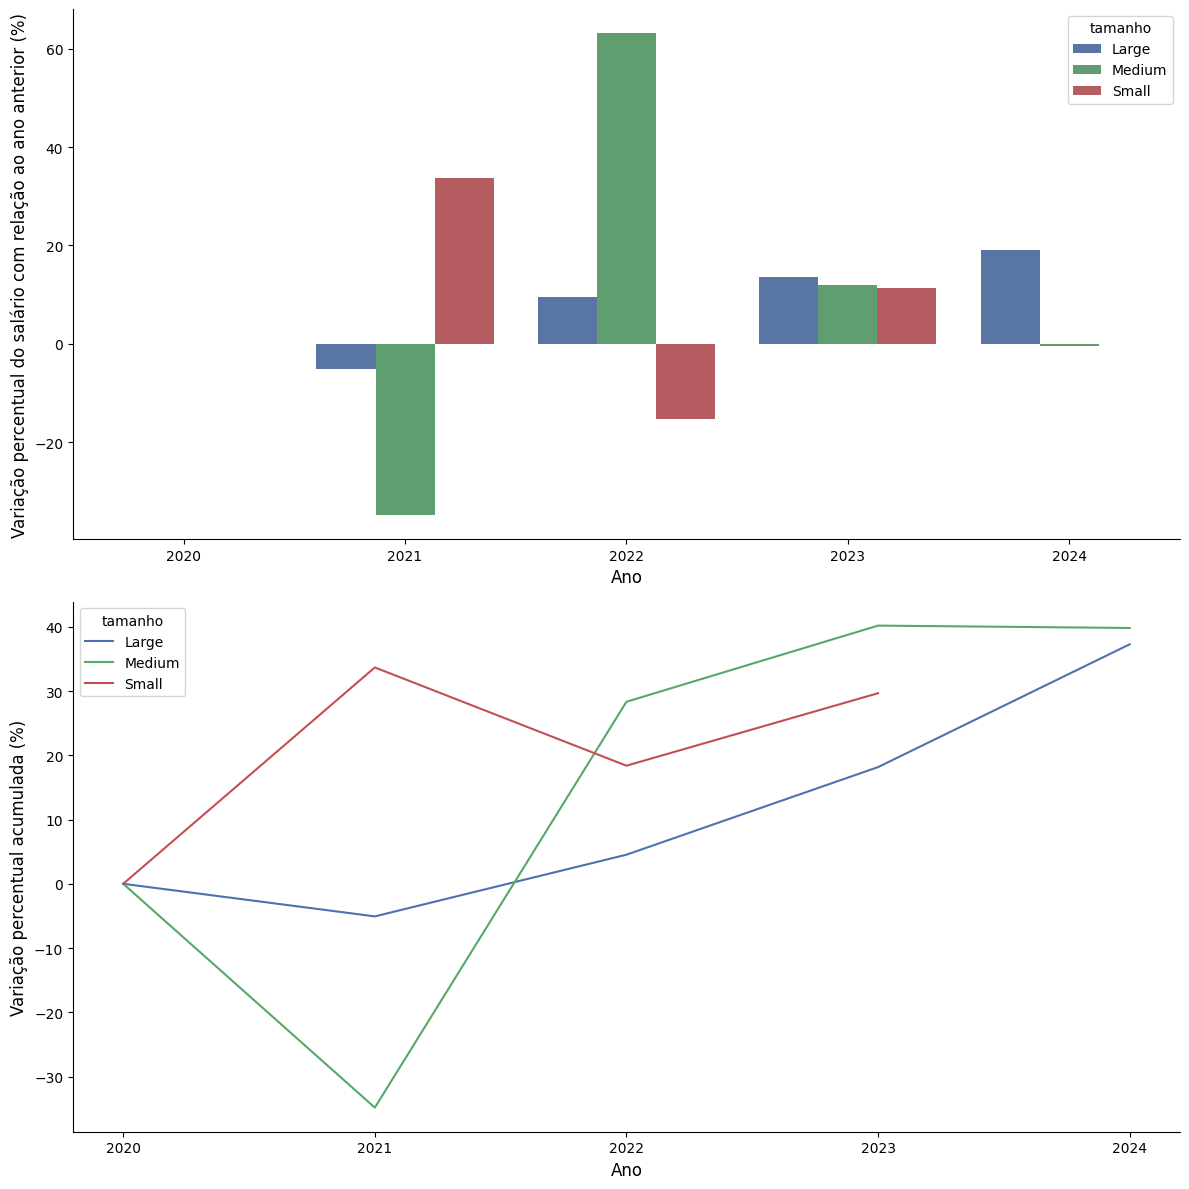

In [40]:
variacao_percentual_salario = {'tamanho':[],'ano':[],'variacao':[]}
for tamanho in aux_salarios['company_size'].unique():
    aux = aux_salarios.query(f'company_size == "{tamanho}"').set_index('work_year')
    for ano in aux.index:
        if ano == 2020:
            valor = 0
        else:
            valor = round(variacao_percentual(aux.loc[ano-1,'mean'],aux.loc[ano,'mean']),2)

        variacao_percentual_salario['tamanho'].append(tamanho)
        variacao_percentual_salario['ano'].append(ano)
        variacao_percentual_salario['variacao'].append(valor)



variacao_percentual_salario = pd.DataFrame(variacao_percentual_salario)
variacao_percentual_salario['cumsum']=variacao_percentual_salario.groupby('tamanho')['variacao'].cumsum()


fig, ax = plt.subplots(2,1,sharex=False,tight_layout=True,figsize=(12,12))

sns.barplot(data = variacao_percentual_salario, x='ano',y='variacao',hue='tamanho',ax=ax[0])
ax[0].set_xlabel('Ano',size=12)
ax[0].set_ylabel('Variação percentual do salário com relação ao ano anterior (%)',size=12)

sns.lineplot(data = variacao_percentual_salario, x='ano',y='cumsum',hue='tamanho',ax=ax[1])
ax[1].set_xlabel('Ano',size=12)
ax[1].set_ylabel('Variação percentual acumulada (%)',size=12)
ax[1].set_xticks(ticks=[2020,2021,2022,2023,2024]);

fig.savefig('../images/variacao_salarioxtamempresa.png')

**Insights**

* Considerando o período de 5 anos, as empresas de tamanho médio são as que mais pagaram em média por ano.

    * Empresa pequena: \$85.449,75
    
    * Empresa média: \$150.700,74

    * Empresa grande: \$121.833,17 

* Empresas grandes estão pagando mais aos seus profissionais de dados com o decorrer dos anos.

* Os salários das empresas grandes estão se tornando competitivos quando comparados aos salários de uma empresa média.

* Uma empresa pequena é menos competitiva em termos de salário.

* Do desvio padrão, observamos que ainda existe uma dispersão salarial considerável entre as empresas ano após ano. Onde essa dispersão se encontra entre \$50.000,00 a \$90.000,00 nos anos de 2023 e 2024.

* Por outro lado, observamos a queda do coeficiente de variação, o que provavelmente é um resultado direto do aumento dos salários.

* Os salários para empresas pequenas e médias sofreram instabilidade no tempo, em determinados momentos sofrem quedas de 10\%-20%, em outras observamos aumentos de  20%~60%. Por outro lado, empresas grandes aparentemente são mais estáveis e provendo aumentos ano a ano.

* Observando a variação acumulada, podemos notar que desde 2020 já acumulam um aumento em torno de 30\%~40\%. Isso indica que o salario para os profissionais de dados teve uma valorização em todos os tipos de empresas.

---
### **2. Como o modelo de trabalho impacta no salário**

Essa análise será similar aquela feita anteriormente, apenas trocando o tamanho da empresa pelo modelo de trabalho

Vamos iniciar verificando a busca por cada modelo de emprego por ano. Neste caso, o ideal seria tomarmos a proporção, pois não desejamos que a análise fique enviesada devido a popularidade do site aumentar.

Text(0, 0.5, 'Proporção (%)')

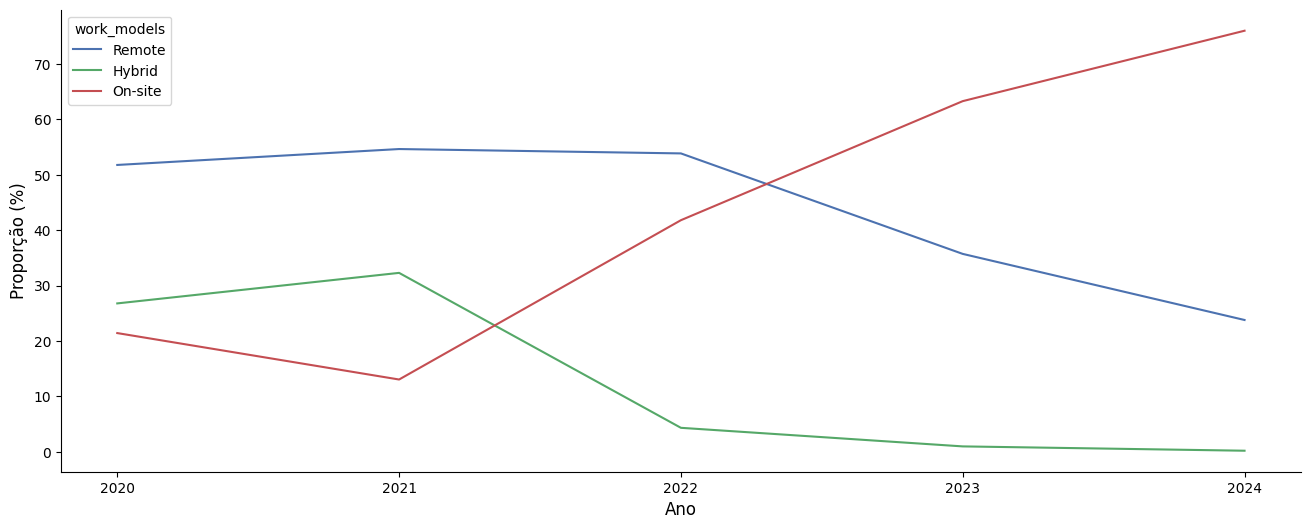

In [41]:
qte_por_ano = estudo.groupby('work_year')['work_models'].value_counts(1).mul(100).to_frame('qte').reset_index()

sns.lineplot(data=qte_por_ano,x='work_year',y='qte',hue='work_models')
plt.xticks(ticks = [2020,2021,2022,2023,2024])
plt.xlabel('Ano',size=12)
plt.ylabel('Proporção (%)',size=12)

Exibindo os dados do gráfico acima em uma tabela

In [42]:
estudo.pivot_table(index = 'work_models',columns='work_year',values='salary_in_usd', margins=True).round(2)

work_year,2020,2021,2022,2023,2024,All
work_models,,,,,,
Hybrid,81245.67,71012.33,72506.58,82215.65,16666.00,75062.26
On-site,107387.17,115603.90,135952.65,155849.97,156811.67,153172.18
Remote,112781.38,112931.10,135599.62,148208.29,143268.46,143107.67
All,103178.41,99740.75,133020.59,152407.92,153329.00,147306.66


Verificando o salário por modelo por ano

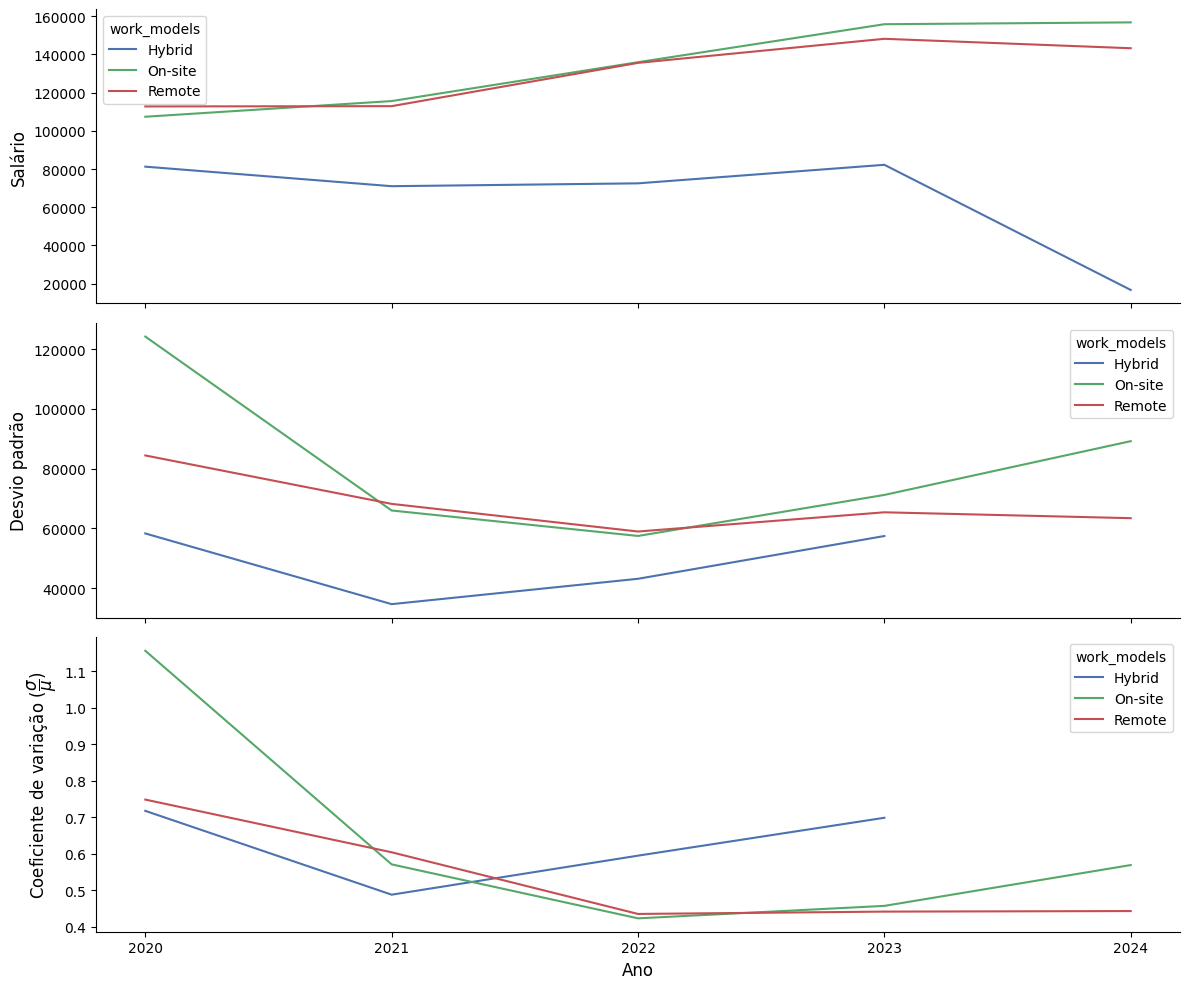

In [43]:
aux_salarios = estudo.groupby(['work_year','work_models'])['salary_in_usd'].agg(['mean','std']).round(2).reset_index()
aux_salarios['coeficiente_variacao'] = aux_salarios['std']/aux_salarios['mean']

fig,ax = plt.subplots(3,1,tight_layout=True,figsize=(12,10),sharex=True)

sns.lineplot(data=aux_salarios,x='work_year',y='mean',hue='work_models',ax=ax[0])
ax[0].set_ylabel('Salário',size=12)


sns.lineplot(data=aux_salarios,x='work_year',y='std',hue='work_models',ax=ax[1])
ax[1].set_ylabel('Desvio padrão',size=12)
ax[1].set_xlabel('Ano',size=12)
ax[1].set_xticks(ticks=[2020,2021,2022,2023,2024]);

sns.lineplot(data=aux_salarios,x='work_year',y='coeficiente_variacao',hue='work_models',ax=ax[2])
ax[2].set_ylabel('Coeficiente de variação $(\dfrac{\sigma}{\mu})$',size=12)
ax[2].set_xlabel('Ano',size=12)
ax[2].set_xticks(ticks=[2020,2021,2022,2023,2024]);

fig.savefig('../images/salarioxworkmodel.png')

Do gráfico acima podemos notar que não existe desvio padrão para o modelo híbrido. Isso ocorre pois em 2024 só temos um registro de salário, logo não há dispersão da média.

Verificando as variações percentuais do salário dado o modelo de trabalho para cada ano

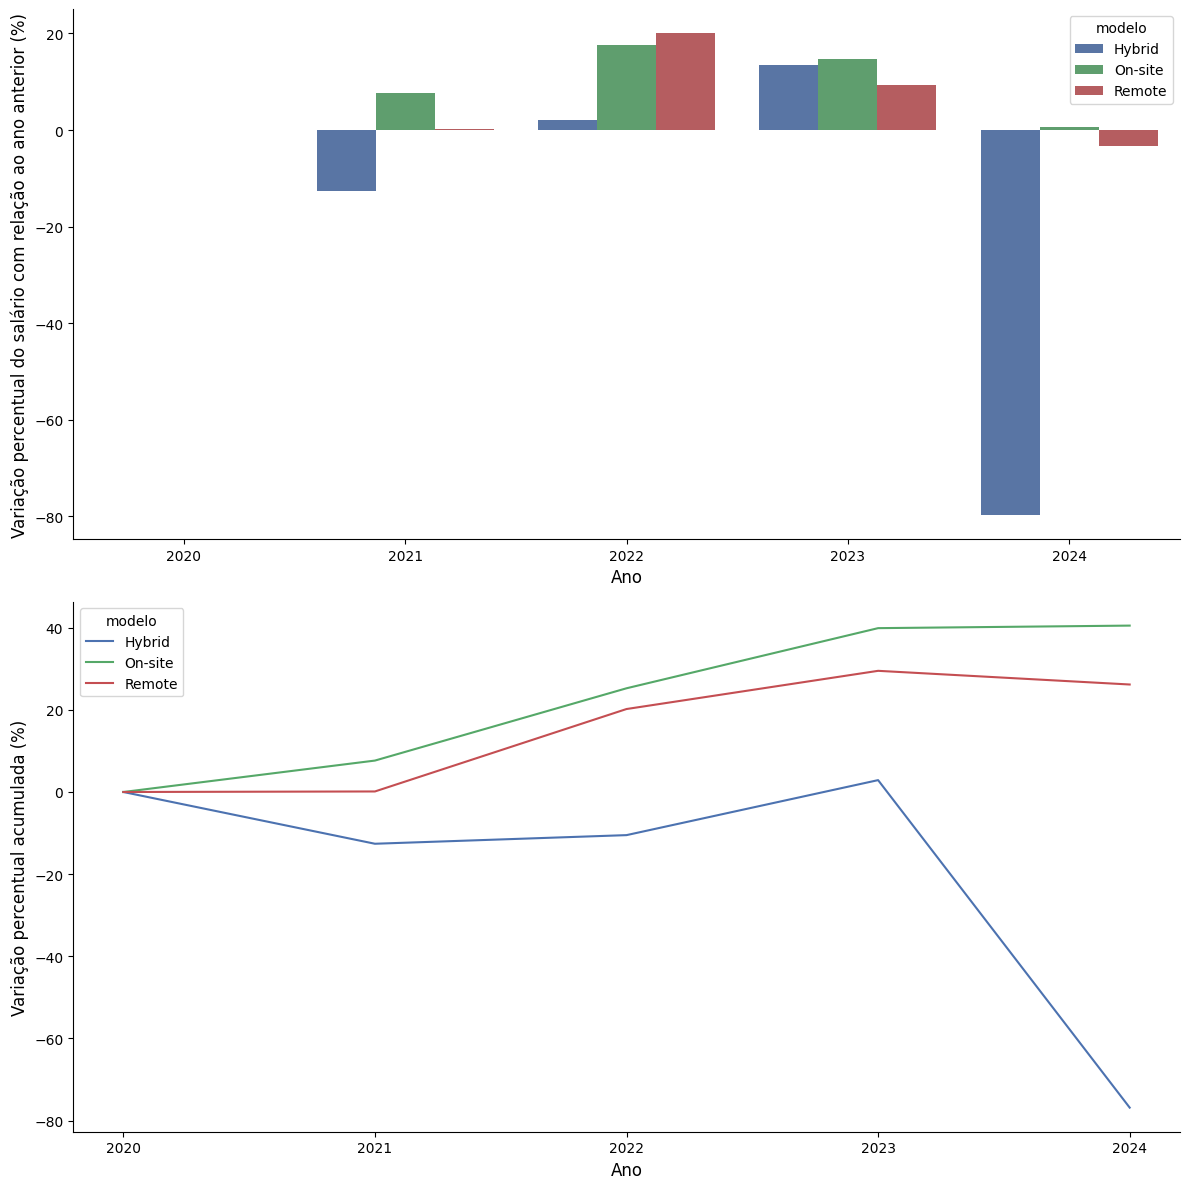

In [44]:
variacao_percentual_salario = {'modelo':[],'ano':[],'variacao':[]}
for tamanho in aux_salarios['work_models'].unique():
    aux = aux_salarios.query(f'work_models == "{tamanho}"').set_index('work_year')
    for ano in aux.index:
        if ano == 2020:
            valor = 0
        else:
            valor = round(variacao_percentual(aux.loc[ano-1,'mean'],aux.loc[ano,'mean']),2)

        variacao_percentual_salario['modelo'].append(tamanho)
        variacao_percentual_salario['ano'].append(ano)
        variacao_percentual_salario['variacao'].append(valor)



variacao_percentual_salario = pd.DataFrame(variacao_percentual_salario)
variacao_percentual_salario['cumsum']=variacao_percentual_salario.groupby('modelo')['variacao'].cumsum()


fig, ax = plt.subplots(2,1,tight_layout=True,figsize=(12,12))

sns.barplot(data = variacao_percentual_salario, x='ano',y='variacao',hue='modelo',ax=ax[0])
ax[0].set_xlabel('Ano',size=12)
ax[0].set_ylabel('Variação percentual do salário com relação ao ano anterior (%)',size=12)

sns.lineplot(data = variacao_percentual_salario, x='ano',y='cumsum',hue='modelo',ax=ax[1])
ax[1].set_xlabel('Ano',size=12)
ax[1].set_ylabel('Variação percentual acumulada (%)',size=12)
ax[1].set_xticks(ticks=[2020,2021,2022,2023,2024]);


fig.savefig('../images/variacao_salarioxworkmodels.png')

**Insights**

* De 2020 até 2021 observamos um ligeiro aumento na busca por cargos híbridos e remotos. Entretanto, no intervalo de 2021 até 2024 esse cenário sofreu uma reversão, onde podemos notar o rápido crescimento do modelo presencial contra a queda dos demais modelos.

* Em 2024 observamos que os cargos remotos ocupam  76\% de toda a base contra os ~24\% do modelo remoto e os irrisórios 0.18\% do modelo híbrido. 

* Com relação aos salários, observamos que o modelo híbrido fica orbitando em torno dos \\$80.000,00 e em 2024 cai para \\$20.000,00. No mais, deveríamos desconsiderar o ano de 2024, pois só há um registro de modelo híbrido para esse ano.

* Não existe muitas diferenças de salário entre os modelos remoto e presencial durante os anos. As diferenças ficam perceptíveis em 2023 e ficam ainda mais discrepantes em 2024, onde o salário dos profissionais em modelo presencial se tornam mais elevados quando comparado aos salários dos profissionais remotos.

* O fato do salário remoto ser menor pode estar relacionado com o país de onde o empregado mora. O dólar frente ao real é bastante valorizado, desse modo, as empresas norte americanas podem nos pagar menos no trabalho remoto e ainda assim estaria melhor que muito salário de empresas brasileiras.

* Os salários mais dispersos ocorrem para os cargos presenciais e apresenta uma tendência de crescimento. Isto é, os profissionais de dados presenciais terão os mais variados salários. Com relação ao remoto não podemos concluir muita coisa, mas a tendência aparenta ser de queda.

* Observamos que os cargos remotos e presenciais apresentaram aumento de salário ano após ano.

---
### **3. Como o modelo de trabalho está relacionado com o tamanho da empresa** 

Verificando o modelo de trabalho por tamanho da empresa

proporcao
company_size work_models           
Large        Remote       41.457859
             On-site      37.357631
             Hybrid       21.184510
Medium       On-site      61.712894
             Remote       37.612444
             Hybrid        0.674663
Small        Remote       62.500000
             Hybrid       19.642857
             On-site      17.857143

Text(0.5, 0, 'Tamanho da empresa')

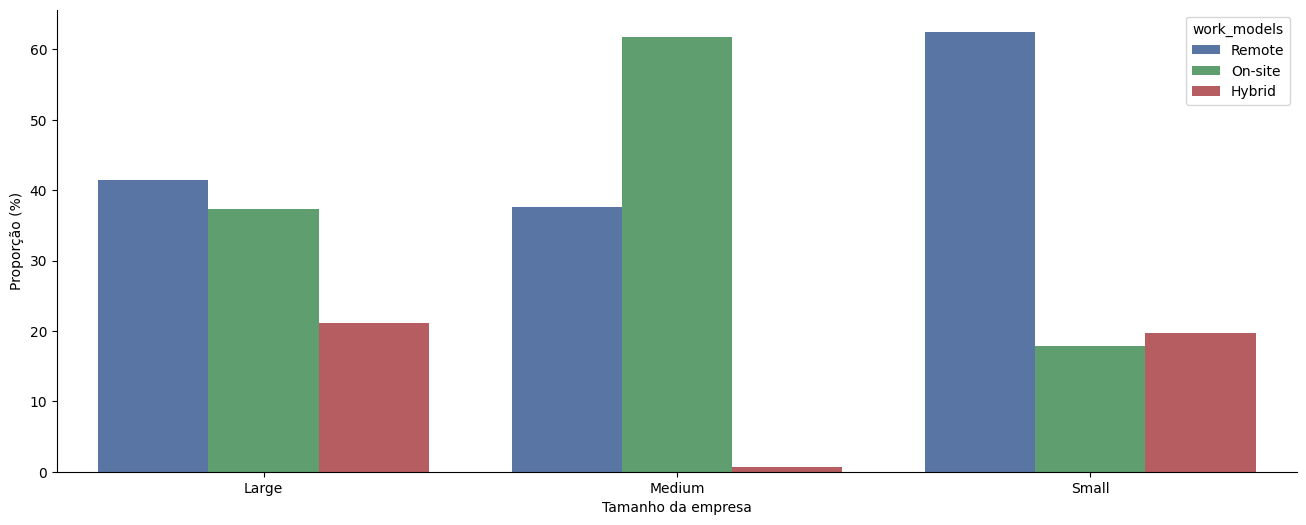

In [45]:
proporcao = estudo.groupby('company_size')['work_models'].value_counts(1).mul(100).to_frame('proporcao')
display(proporcao)
sns.barplot(data = proporcao.reset_index(), x='company_size',y = 'proporcao',hue='work_models')
plt.ylabel('Proporção (%)')
plt.xlabel('Tamanho da empresa')

Verificando o salário por tamanho da empresa e modelo de trabalho

In [46]:
estudo.pivot_table(index = 'company_size', columns = 'work_models', values='salary_in_usd', margins = True).round(2)

work_models,Hybrid,On-site,Remote,All
company_size,,,,
Large,81559.05,152940.73,114381.82,121833.17
Medium,58765.83,153411.76,147901.68,150700.74
Small,74265.41,115623.50,80343.76,85449.75
All,75062.26,153172.18,143107.67,147306.66


Text(0.5, 0, 'Tamanho da empresa')

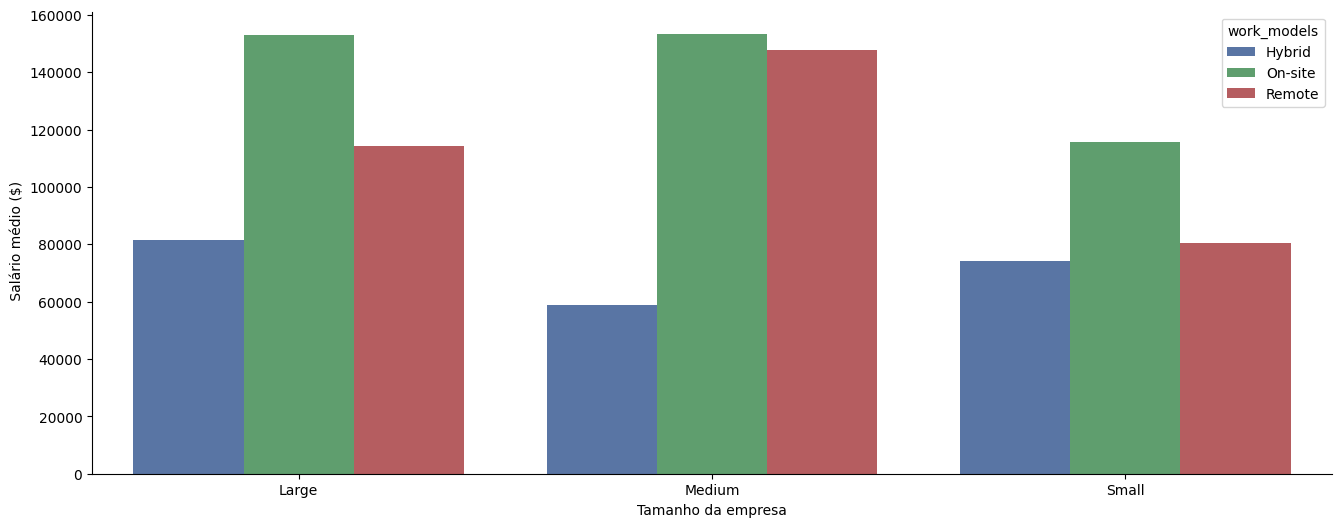

In [47]:
aux_sal = estudo.groupby(['work_models','company_size'])['salary_in_usd'].mean().to_frame().round(2).reset_index()

sns.barplot(data = aux_sal , x='company_size', y='salary_in_usd', hue='work_models')
plt.ylabel(' Salário médio ($)')
plt.xlabel('Tamanho da empresa')

**Insights**

* **Empresas grandes**
    * Apresenta proporções parecidas de empregos remotos e presenciais ~40\%. O modelo híbrido representa 20\% dos cargos.

    * Os salários para presenciais são os mais elevados, seguido de remoto e por fim híbridos

    

* **Empresas Médias**
    * ~60\% dos cargos são presencias e ~20\% de cargos são remotos. Oportunidades para híbridos é basicamente inexistente.

    * Os salários para cargos remotos e presenciais são parecidos. Salários para híbridos corresponde a ~\\$60.000,00 e os demais ~\\$150.000,00 

* **Empresas pequenas**
    * Cerca de ~60\% dos cargos são remotos, ~20\% híbridos e ~20\% presencial.

    * Salários mais elevados para presencial, em seguida os remotos e por fim os híbridos

---
### **4. Como o nível de experiência de um indivíduo impacta no seu salário e na sua carreira**

Verificando como o nível de experiencia de um individuo se relaciona com o seu salário

In [48]:
estudo.pivot_table(index='experience_level',columns='work_year',values='salary_in_usd',margins=True).round(2)

work_year,2020,2021,2022,2023,2024,All
experience_level,,,,,,
Entry-level,70941.47,68580.89,72726.63,92323.37,92433.11,86477.54
Executive-level,202416.50,193546.67,188164.56,186145.80,187616.62,186959.00
Mid-level,96479.96,85581.84,102887.07,126695.03,135585.54,121406.67
Senior-level,146262.83,128405.46,149580.41,166012.67,171974.98,163097.64
All,103178.41,99740.75,133020.59,152407.92,153329.00,147306.66


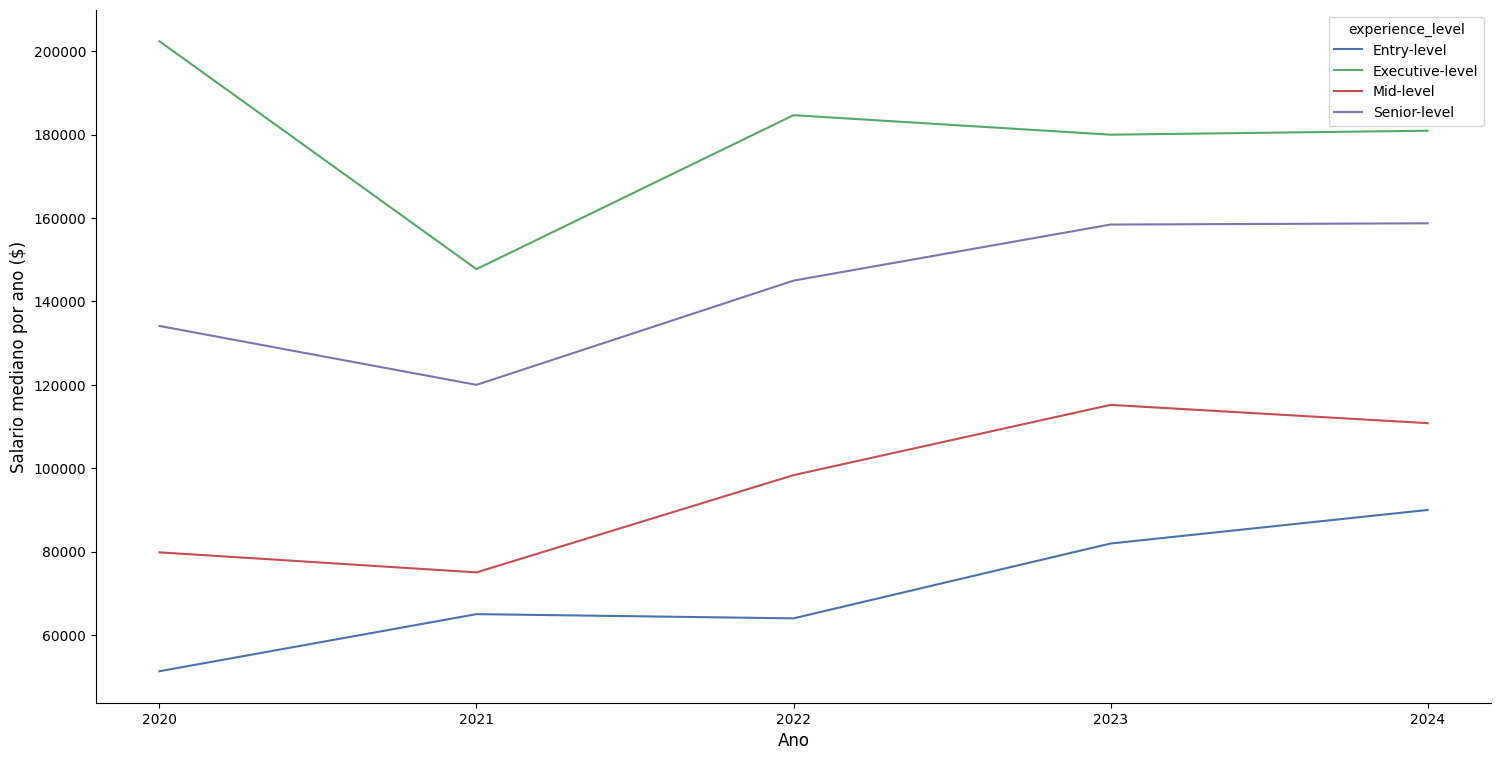

In [49]:
salario_por_exp = estudo.groupby(['work_year','experience_level'])['salary_in_usd'].median().round(2).to_frame('salario').reset_index()

plt.figure(figsize=(18,9))
sns.lineplot(data = salario_por_exp, x='work_year', y='salario',hue='experience_level')
plt.xticks(ticks=[2020,2021,2022,2023,2024])
plt.xlabel('Ano',size=12)
plt.ylabel('Salario mediano por ano ($)',size=12);

Verificando como a proporção de cada nível se comporta no tempo

proporcao
work_year experience_level           
2020      Mid-level         44.642857
          Entry-level       30.357143
          Senior-level      21.428571
          Executive-level    3.571429
2021      Mid-level         42.236025
          Senior-level      32.298137
          Entry-level       21.739130
          Executive-level    3.726708
2022      Senior-level      63.919598
          Mid-level         24.723618
          Entry-level        8.140704
          Executive-level    3.216080
2023      Senior-level      66.279913
          Mid-level         23.011844
          Entry-level        7.154943
          Executive-level    3.553299
2024      Senior-level      54.646840
          Mid-level         33.828996
          Entry-level        8.550186
          Executive-level    2.973978

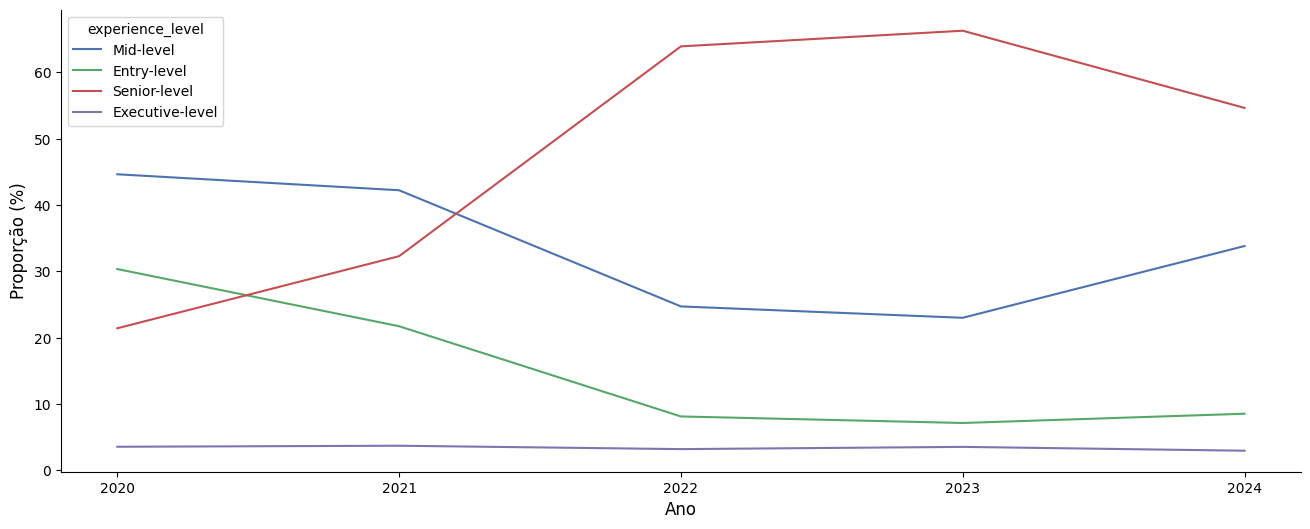

In [50]:
nivel_por_ano = estudo.groupby(['work_year'])['experience_level'].value_counts(1).mul(100).to_frame('proporcao')

display(nivel_por_ano)


sns.lineplot(data = nivel_por_ano.reset_index(), x='work_year', y='proporcao',hue='experience_level')
plt.xticks(ticks=[2020,2021,2022,2023,2024])
plt.xlabel('Ano',size=12)
plt.ylabel('Proporção (%)',size=12);

Verificando como o modelo de trabalho e o nível de experiencia estão relacionados

proporcao
work_models experience_level           
Hybrid      Mid-level         42.384106
            Entry-level       33.112583
            Senior-level      21.192053
            Executive-level    3.311258
On-site     Senior-level      63.618062
            Mid-level         25.970664
            Entry-level        7.391429
            Executive-level    3.019845
Remote      Senior-level      66.046923
            Mid-level         22.399292
            Entry-level        7.436919
            Executive-level    4.116866

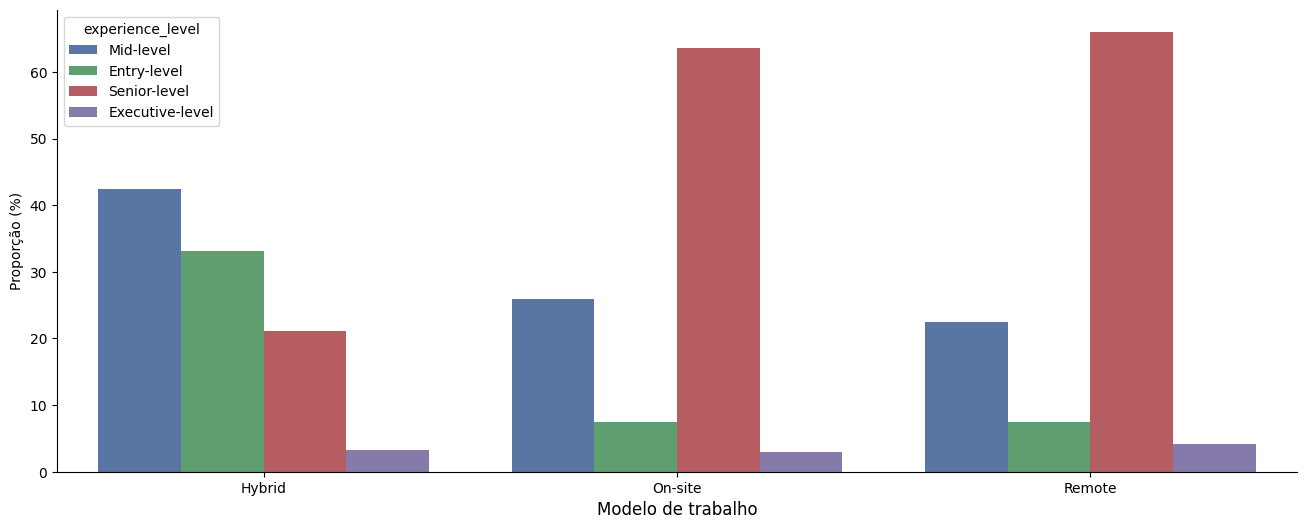

In [51]:
modo_xp = estudo.groupby(['work_models'])['experience_level'].value_counts(1).to_frame('proporcao').mul(100)
display(modo_xp)
sns.barplot(data=modo_xp.reset_index(),x='work_models',y='proporcao',hue='experience_level')
plt.xlabel('Modelo de trabalho',size=12)
plt.ylabel('Proporção (%)');

Verificando a relação entre o nível de experiência e o tamanho da empresa

proporcao
company_size experience_level           
Large        Senior-level      44.646925
             Mid-level         33.257403
             Entry-level       19.589977
             Executive-level    2.505695
Medium       Senior-level      65.723388
             Mid-level         24.062969
             Entry-level        6.727886
             Executive-level    3.485757
Small        Mid-level         38.392857
             Senior-level      29.464286
             Entry-level       26.785714
             Executive-level    5.357143

Text(0, 0.5, 'Proporção (%)')

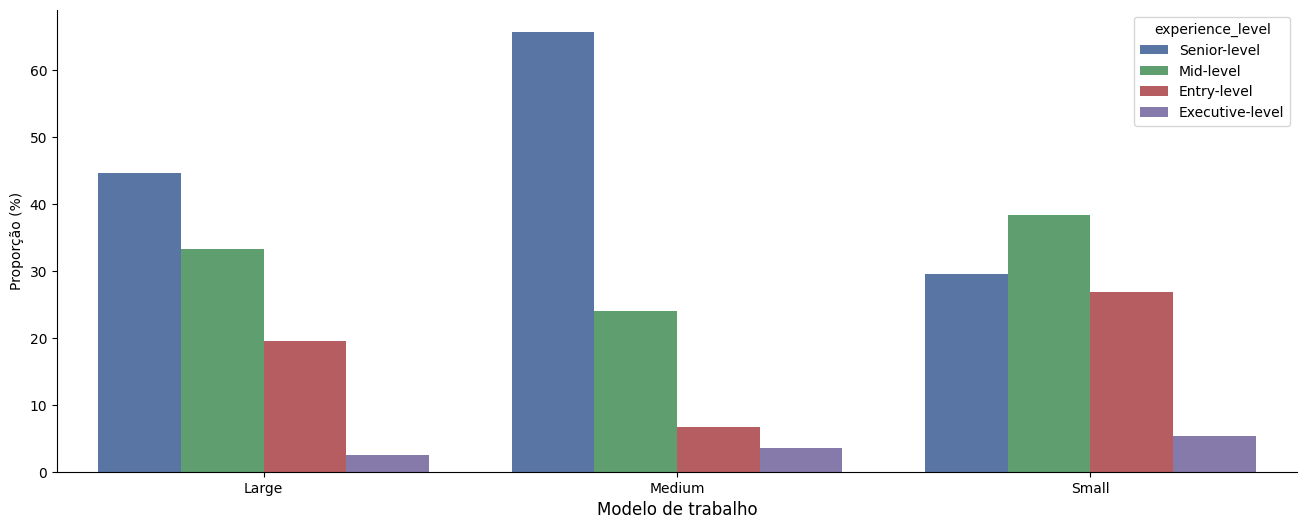

In [52]:
tam_xp = estudo.groupby(['company_size'])['experience_level'].value_counts(1).to_frame('proporcao').mul(100)
display(tam_xp)
sns.barplot(data=tam_xp.reset_index(),x='company_size',y='proporcao',hue='experience_level')
plt.xlabel('Modelo de trabalho',size=12)
plt.ylabel('Proporção (%)')

**Insights**

* Observa-se que o nível de experiência tem impacto direto no salário do profissional, bem como esperado. Dito isso, quanto maior o nível de experiência, maior tenderá a ser o salário.

* Notamos uma queda de 30\% para ~10\% de 2020 a 2024 na proporção de cargos junior. O mesmo fenômeno de queda ocorre com os profissionais pleno, com uma aparente melhora em janeiro de 2024. Por outro lado, observamos a tendência contrária para os cargos sênior, a demanda por esse tipo de profissional apresentou uma tendencia crescente desde 2020. 

* Levando em consideração que estamos com dados de um site de empregos, isso pode significar que os profissionais pleno e junior estão diminuindo suas buscas por empregos nesse site? Ou o problema está nas vagas ofertadas? Existe muito mais vagas em aberto para sênior? 

>* **Modo de trabalho versus experiência:**
>
>    * **Híbrido:**
>        * Notamos uma proporção elevada de ~42\% para plenos, ~33\% para juniores , 21\% para sêniores e 3\% para executivos. 
>    
>    * **Presencial**
>        * Observamos uma presença elevada de sêniores (~63\%, 25\% de plenos e os outros dois cargos juntos somam 10\%
>        
>    * **Remoto**
>        * Proporções similares ao modelo presencial.
        

* As proporções observadas para cada nível de experiencia e modelo de trabalho reflete a realidade ou é uma característica dos usuários do site? Pois como vimos anteriormente, a proporção de juniores e plenos estão diminuindo ano a ano, mas a hipótese levantada para explicar isso sugere que seja algum aspecto do site que oferece/divulga essas vagas.

>* **Tamanho da empresa versus experiência:**
>
>    * **Grande:**
>       * Nota-se uma proporção maior de profissionais sêniores (~44\%) quando comparado aos outros níveis de experiência. Para plenos temos 33\%, ~19\% para juniores e ~2\% para executivos.
>       
>       * Empresas grandes aparentam optar por profissionais de senioridade maior e, de certo modo, mais qualificados. Uma possível explicação seja o nível de responsabilidade assumidos por essas empresas, visto que em muitos casos o produto oferecido deve garantir um nível de excelência superior e, portanto, a margem para erros de uma empresa grande naturalmente deve ser menor. 
>
>    * **Média:**
>      * Observamos um comportamento similar ao das empresas grandes no que diz respeito a proporção na senioridade. Há  muito mais sêniores (~65\%) do que os demais níveis. Obtemos 24\% para plenos, 6\% para juniores e 3\% para executivos.
>
>      * A proporção de sêniores dado os demais níveis está relacionado com as responsabilidades e riscos assumido pelas empresas ou seria, novamente, uma característica do site? 
>
>    * **Pequena:**
>      * Diferente das demais, as empresas pequenas apresentam uma proporção mais homogênea entre os diferentes níveis de experiência. Podemos observar quase a mesma proporção de sêniores e juniores. Para plenos temos ~38\%, para juniores ~26\%, para sêniores ~29\% e 5\% para executivos. 
>
>      * Seria significativa a diferença entre as proporções de pleno, sênior e junior?  Seria necessário realizar um teste de hipótese para respondermos a essa pergunta.
>
>      * Uma possível explicação para uma empresa pequena ser mais homogênea pode estar no fato dessa ser menos competitiva.  



---
### **5. Como a profissão afeta no seu salário e na sua forma de trabalho**

Verificando o salário mediano anual para cada cargo ano após ano.

In [53]:
estudo.pivot_table(index='job_title',columns='work_year',values='salary_in_usd', aggfunc='median',margins=True).round(2)

work_year,2020,2021,2022,2023,2024,All
job_title,,,,,,
AI Engineer,NaN,NaN,NaN,167000.0,131250.0,163000.0
Analytics Engineer,NaN,NaN,135000.0,150000.0,130471.5,145650.0
Applied Scientist,NaN,NaN,191475.0,184950.0,217106.5,191475.0
BI Developer,NaN,NaN,125000.0,101000.0,91000.0,100000.0
Business Intelligence Analyst,NaN,NaN,NaN,113000.0,95000.0,112500.0
Business Intelligence Engineer,NaN,NaN,NaN,141000.0,132300.0,141000.0
Data Analyst,85000.0,67808.5,102640.0,103200.0,100000.0,100000.0
Data Analytics Manager,NaN,120000.0,140000.0,140000.0,84500.0,140000.0
Data Architect,NaN,170000.0,167500.0,155000.0,154500.0,155000.0


Observamos que em alguns anos existe cargos com salário ausente, isto significa que naquele ano não houve a ocorrência daquele cargo.

Verificando as profissões com os maiores salários medianos

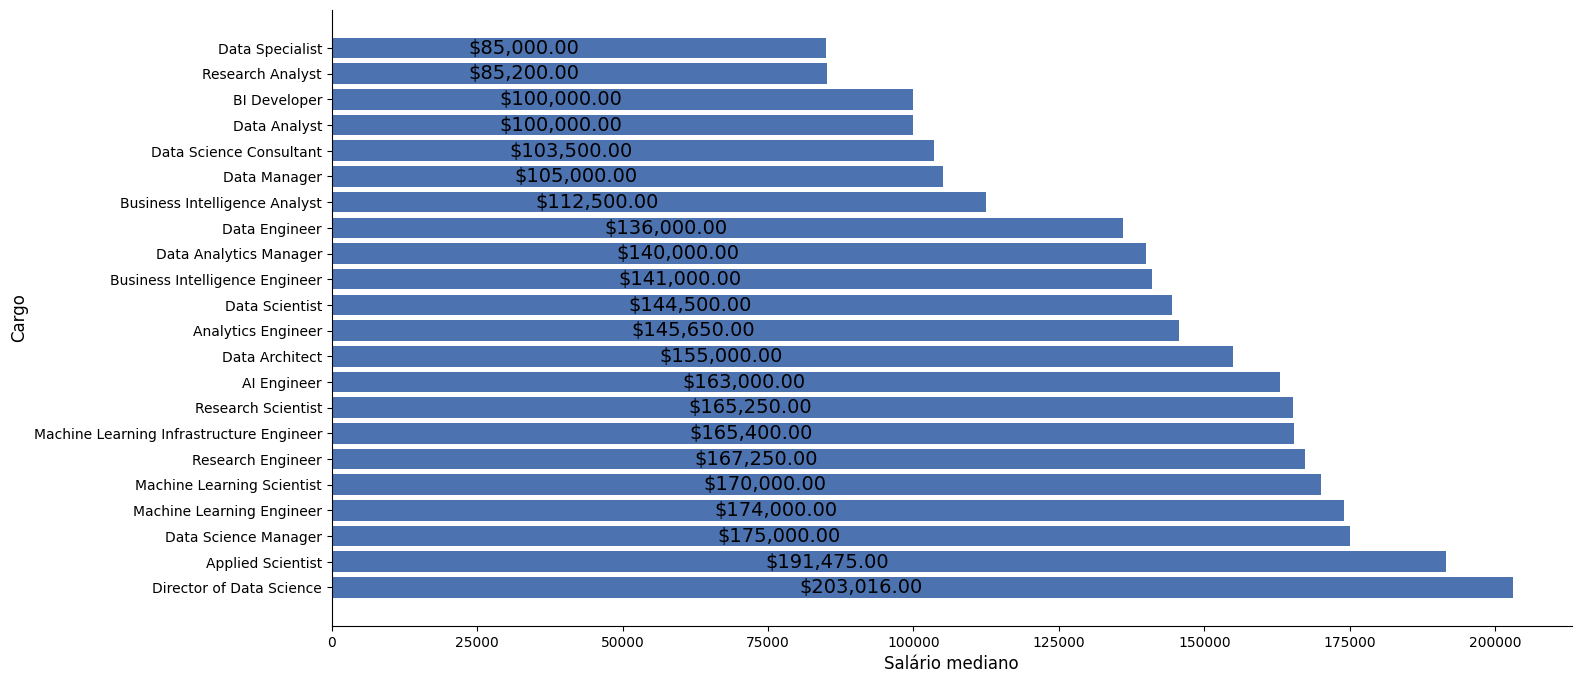

In [131]:
salario_por_profissao = estudo.groupby('job_title')['salary_in_usd'].median().to_frame('salario_mediano').round(2).sort_values(by='salario_mediano',ascending=False).reset_index()

plt.figure(figsize=(16,8))
plt.barh(y = salario_por_profissao['job_title'], width = salario_por_profissao['salario_mediano'])
plt.ylabel('Cargo',size=12)
plt.xlabel('Salário mediano', size=12)

for _, row in salario_por_profissao.iterrows():
    plt.text(x = row['salario_mediano']/2 , y = row['job_title'] , s = f'${row["salario_mediano"]:,.2f}',ha='right', va='center', color='black',size=14, fontweight = 550 )
    

**Insights**

---
### **6. Quais as diferenças entre os profissionais com maiores salários quando comparados aos profissionais com menores salários?**

Vamos estabelecer um limiar para podermos definir o que é um salário baixo e um salário alto. Faremos isso através dos quantis. Para isso, vamos calcular onde se encontra 95% dos salários, a região que estiver acima será considerada os salários altos e a região abaixo os salários baixos.

In [55]:
x_inf = np.quantile(estudo['salary_in_usd'],q=0.025)
x_sup = np.quantile(estudo['salary_in_usd'],q=0.975)

print(x_inf,x_sup)

menor_salario = estudo.query(f'salary_in_usd < {x_inf}')
maior_salario = estudo.query(f'salary_in_usd > {x_sup}')

40789.0 299500.0


Características das pessoas com os menores salários 

<Axes: xlabel='proportion', ylabel='employee_residence'>

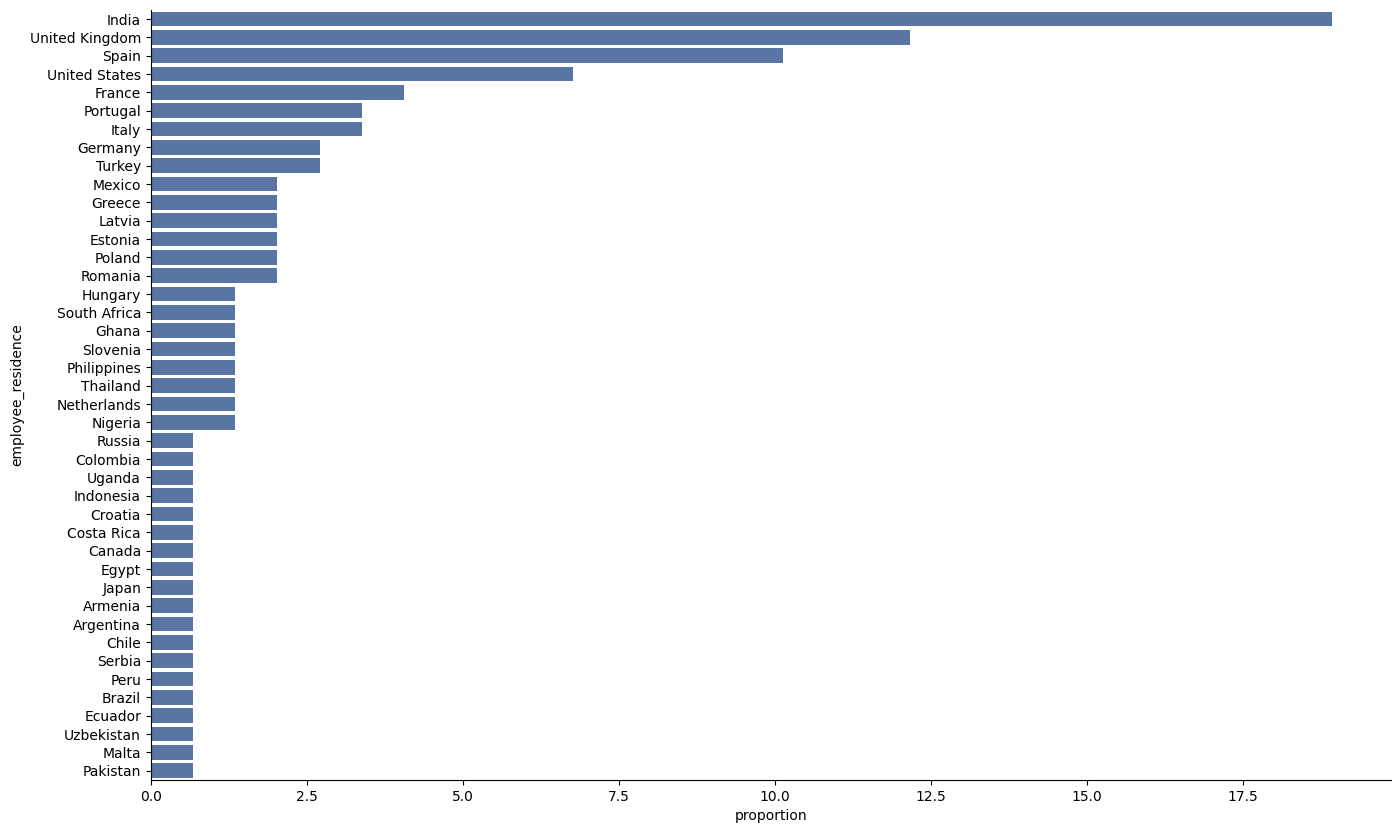

In [65]:
plt.figure(figsize=(16,10))
sns.barplot(data = menor_salario['employee_residence'].value_counts(1).mul(100).to_frame().reset_index(), y='employee_residence', x='proportion')

<Axes: xlabel='proportion', ylabel='company_location'>

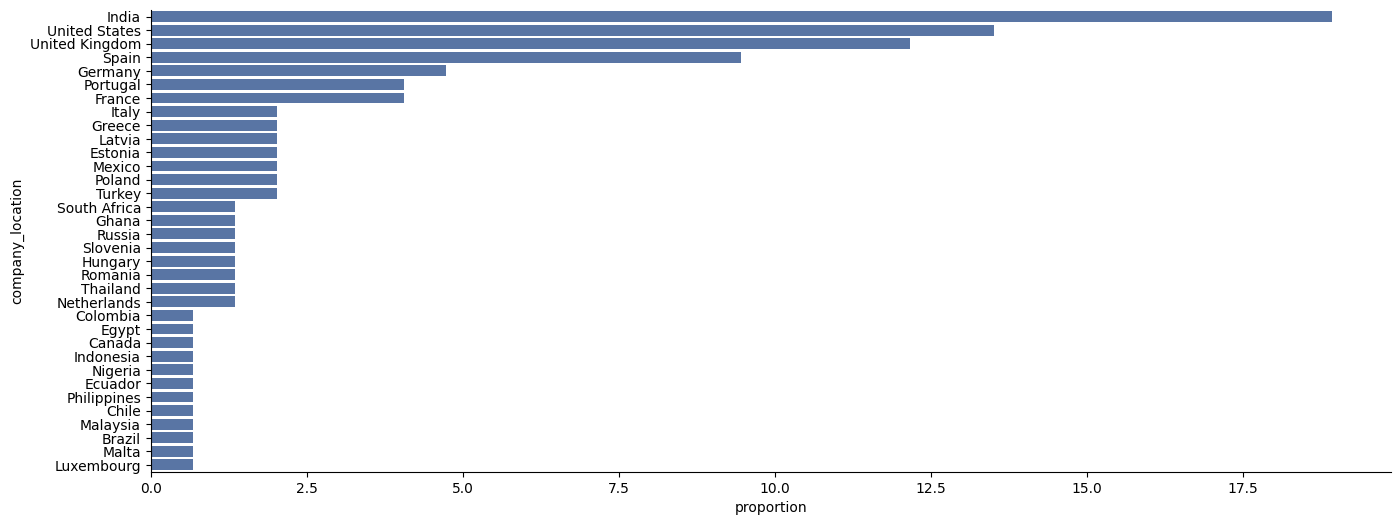

In [57]:
sns.barplot(data = menor_salario['company_location'].value_counts(1).mul(100).to_frame().reset_index(), y='company_location', x='proportion')

menores salarios são trabalhadores remotos

<Axes: xlabel='proportion', ylabel='work_models'>

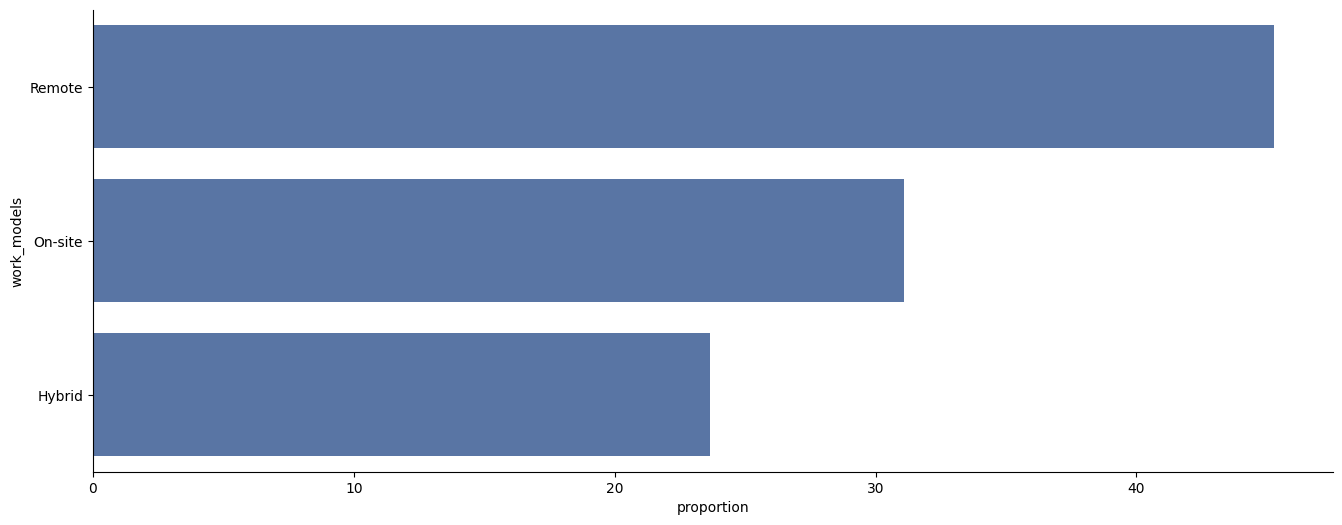

In [58]:
sns.barplot(data = menor_salario['work_models'].value_counts(1).mul(100).to_frame().reset_index(), y='work_models', x='proportion')

características para o maior salario

<Axes: xlabel='proportion', ylabel='employee_residence'>

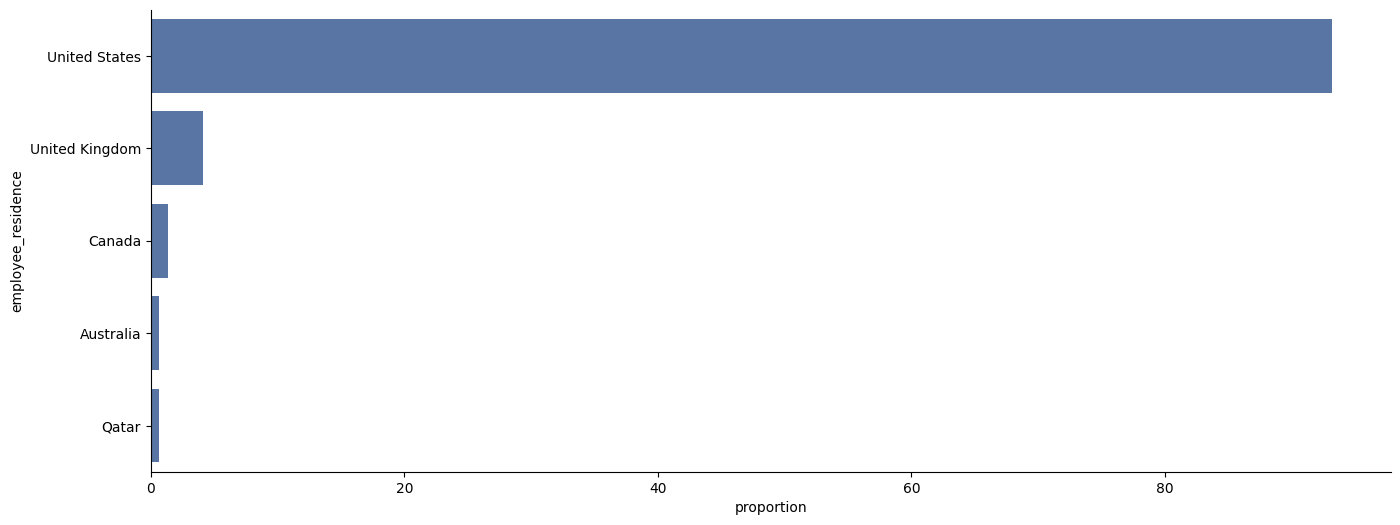

In [59]:
sns.barplot(data = maior_salario['employee_residence'].value_counts(1).mul(100).to_frame().reset_index(), y='employee_residence', x='proportion')

<Axes: xlabel='proportion', ylabel='company_location'>

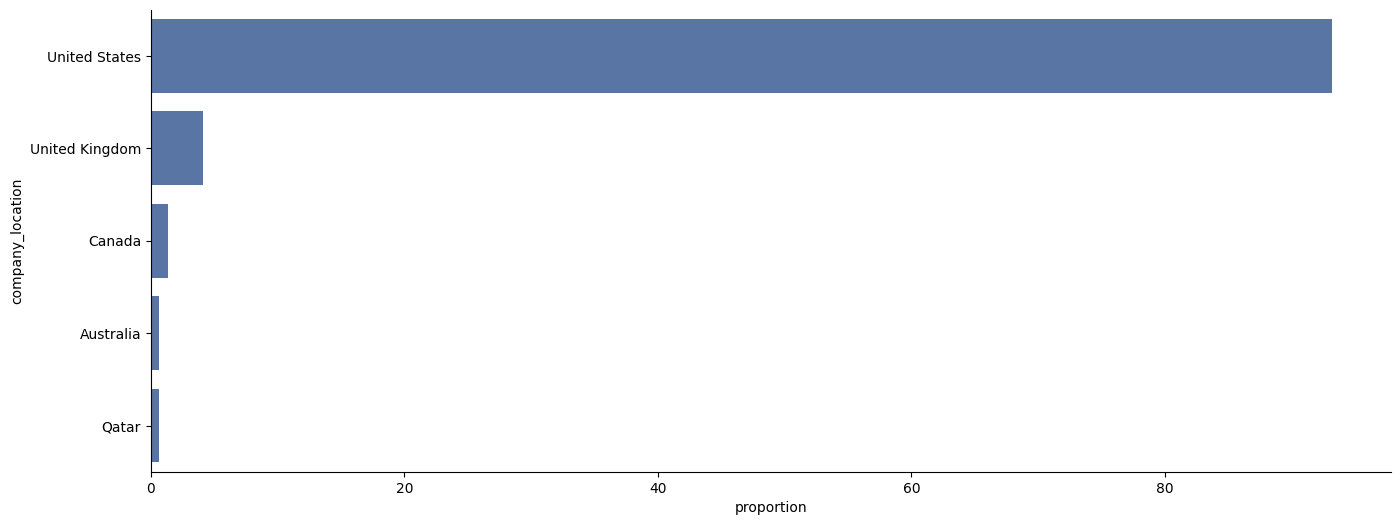

In [60]:
sns.barplot(data = maior_salario['company_location'].value_counts(1).mul(100).to_frame().reset_index(), y='company_location', x='proportion')

<Axes: xlabel='proportion', ylabel='work_models'>

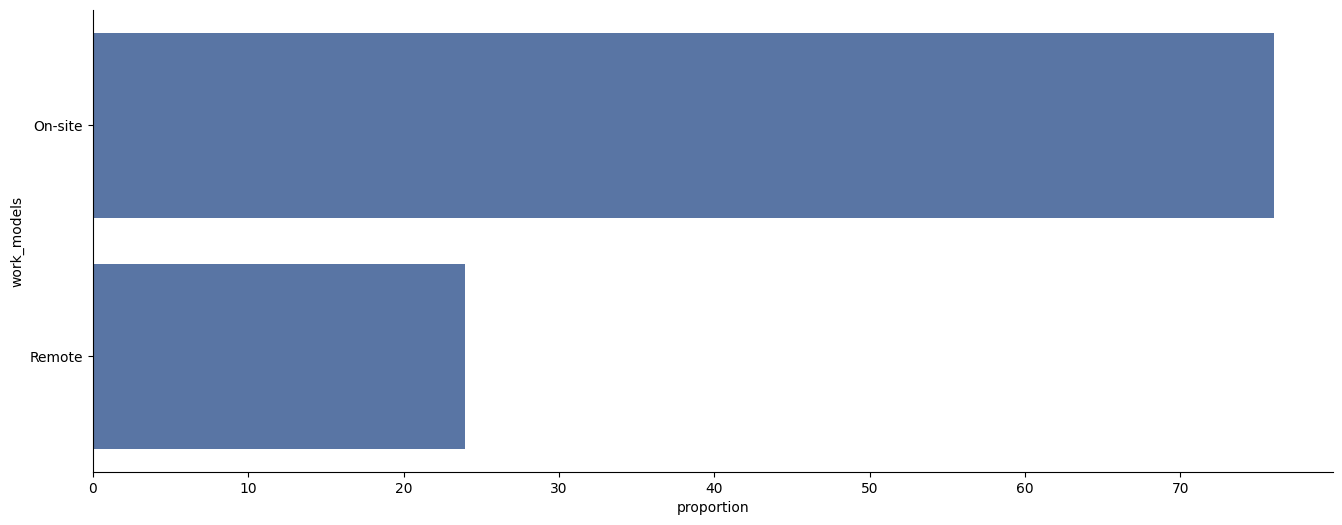

In [61]:
sns.barplot(data = maior_salario['work_models'].value_counts(1).mul(100).to_frame().reset_index(), y='work_models', x='proportion')

Vimos que os Estados Unidos é o país mais persistente na base. Será que existe diferença para o salário de profissionais dos Estados Unidos e de outros países?

In [62]:
estudo['estrangeiro'] = np.where(estudo['company_location'] != estudo['employee_residence'],'Estrangeiro','Local')

<Axes: xlabel='estrangeiro'>

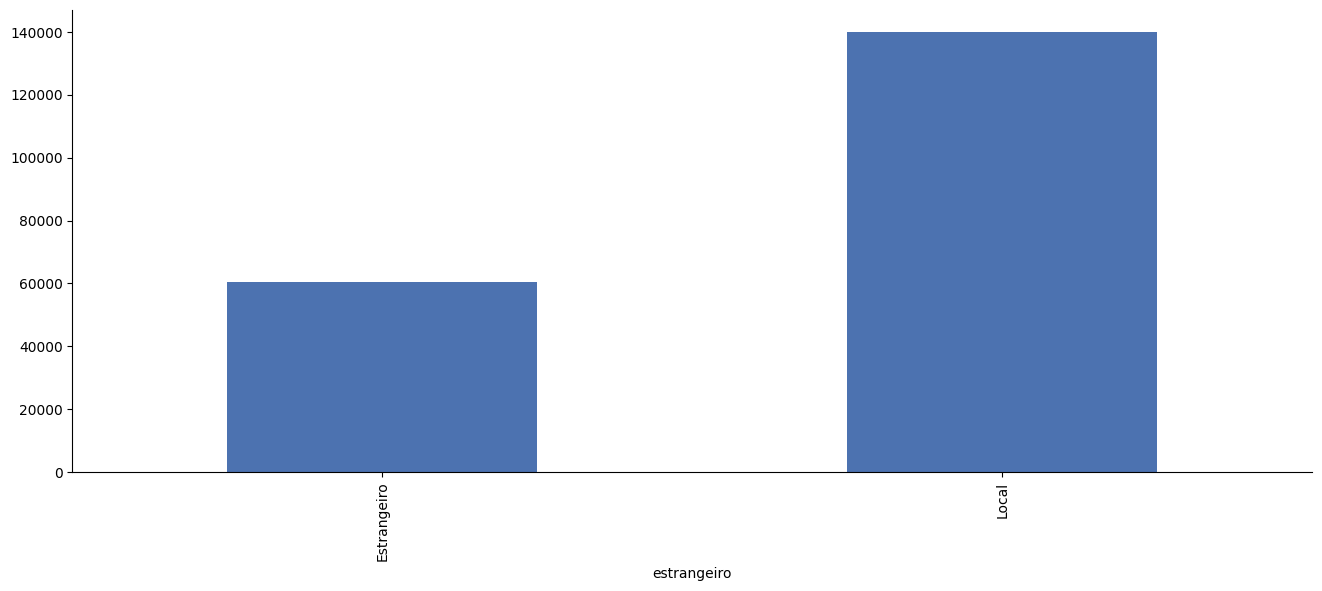

In [63]:
estudo.groupby('estrangeiro')['salary_in_usd'].median().round(2).plot.bar()

**Insights**